In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import pymc3 as pm
import scipy as sp
import pyccl as ccl
import os
import utils
from make_data import MakeData
import getdist
from getdist import plots, MCSamples
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load data

In [3]:
names_planck  = ['H0_gp', 'omega_m', 's80', 'S80']
labels_planck = [r'H_0', r'\omega_{\rm{m}}', r'\sigma_{\rm{8}}',  r'\S_{\rm{8}}']

planck1 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_1.txt')
planck2 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_2.txt')
planck3 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_3.txt')
planck4 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_4.txt')

planck_tot = np.concatenate((planck1, planck2, planck3, planck4), axis=0)

planck_params = []
for item in planck_tot:
    planck_params.append([item[29], item[32], item[34], item[35]])
planck_params = np.array(planck_params)
planck_samples = MCSamples(samples=planck_params, names = names_planck, labels = labels_planck, label= r'$Planck$ 2018',
                    weights=np.transpose(planck_tot)[0],loglikes=np.transpose(planck_tot)[1])

Removed no burn in


In [4]:
z_max = 1110
res = 200
x_arr = np.linspace(0, np.log(1+z_max), res)
dx = np.mean(np.diff(x_arr))
z_arr = np.exp(x_arr)-1
a_arr = 1./(1+z_arr)

path = '/home/jaimerz/PhD/Growz/data/products'

data_class = MakeData(z_max, res , path)
Planck = data_class.Planck
z_planck = data_class.z_planck
c = data_class.c

DESI_data = data_class.get_DESI(new=True, mode=None)
WFIRST_data = data_class.get_WFIRST(new=True)
CC_data = data_class.get_CC(new=True)
DSS_data = data_class.get_DSS(new=True)
BOSS_data = data_class.get_BOSS(new=True)
eBOSS_data = data_class.get_eBOSS(new=True)
Wigglez_data = data_class.get_Wigglez(new=True)
DS17_data = data_class.get_DS17(new=True)
CMB_data = data_class.get_CMB(new=True)
FCMB_data = data_class.get_FCMB(new=True)

In [5]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [6]:
#LCDM 
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'LCDM/'
LCDM = np.load(os.path.join(path,'LCDM_All_CMB_10000_10000/samples.npz'))

#Fiducials
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'fiducial/'
All = np.load(os.path.join(path,'All_10000_10000/samples.npz'))
All_gro = np.load(os.path.join(path,'All_gro_30000_30000/samples.npz'))
All_CMB = np.load(os.path.join(path,'All_CMB_50000_50000/samples.npz'))
All_CMB_NODSS = np.load(os.path.join(path,'All_CMB_NODSS_10000_10000/samples.npz'))
All_CMB_geo = np.load(os.path.join(path,'All_CMB_geo_30000_30000/samples.npz'))
All_CMB_gro = np.load(os.path.join(path,'All_CMB_gro_30000_30000/samples.npz'))
All_CMB_gro_CMB = np.load(os.path.join(path,'All_CMB_gro_30000_30000/samples.npz'))
SDSS_CMB = np.load(os.path.join(path,'SDSS_CMB_30000_30000/samples.npz'))
Add_CMB = np.load(os.path.join(path,'Add_CMB_30000_30000/samples.npz'))

#Forecasts
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'forecast/'
DESI_gro = np.load(os.path.join(path,'DESI_gro_10000_10000/samples.npz'))
DESI_gro_nowm = np.load(os.path.join(path,'DESI_gro_nowm_10000_10000/samples.npz'))
DESI_CMB = np.load(os.path.join(path,'DESI_CMB_10000_10000/samples.npz'))
DESI_CMB_nowm = np.load(os.path.join(path,'DESI_CMB_nowm_10000_10000/samples.npz'))
DESI_CMB_geo = np.load(os.path.join(path,'DESI_CMB_geo_10000_10000/samples.npz'))
WFIRST_CMB = np.load(os.path.join(path,'WFIRST_CMB_10000_10000/samples.npz'))

#Alternatives
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'alternative/'
All_CMB_hp = np.load(os.path.join(path,'All_CMB_hp_10000_10000/samples.npz'))
All_CMB_gro_hp = np.load(os.path.join(path,'All_CMB_gro_hp_10000_10000/samples.npz'))
All_CMB_geo_hp = np.load(os.path.join(path,'All_CMB_geo_hp_30000_30000/samples.npz'))
All_CMB_fm = np.load(os.path.join(path,'All_CMB_fm_10000_10000/samples.npz'))
All_CMB_nowm = np.load(os.path.join(path,'All_CMB_nowm_10000_10000/samples.npz'))
All_gro_nowm = np.load(os.path.join(path,'All_gro_nowm_10000_10000/samples.npz'))
All_gro_tight = np.load(os.path.join(path,'All_gro_10eta_10000_10000/samples.npz'))

#Wm
path = '/home/jaimerz/PhD/Growz/data/outputs/'
path += 'Wm/'
All_CMB_Wm = np.load(os.path.join(path,'All_CMB_Wm_15000_15000/samples.npz'))
All_gro_Wm = np.load(os.path.join(path,'All_gro_Wm_15000_15000/samples.npz'))
All_gro_noWm = np.load(os.path.join(path,'All_gro_noWm_15000_15000/samples.npz'))

# Numbers

In [7]:
def table_numbers(samples, sample_names):
    for i, sample in enumerate(samples):
        print(sample_names[i])
        #if 'n' in sample.files:
        #    n = sample['n']
        #    n_m = np.mean(n)
        #    n_s = np.std(n)
        #    print('n', n_m, '+/-', n_s)
        if 'H0_gp' in sample.files:
            H0 = sample['H0_gp']
            H0_m = np.mean(H0)
            H0_s = np.std(H0)
            print('H0', H0_m, '+/-', H0_s)
        if 'S80' in sample.files:
            S80 = sample['S80']
            S80_m = np.mean(S80)
            S80_s = np.std(S80)
            print('S80', S80_m, '+/-', S80_s)
        if 's80' in sample.files:
            s80 = sample['s80']
            s80_m = np.mean(s80)
            s80_s = np.std(s80)
            print('s80', s80_m, '+/-', s80_s)
        if 'omega_m' in sample.files:
            wm = sample['omega_m']
            wm_m = np.mean(wm)
            wm_s = np.std(wm)  
            print('wm0', wm_m, '+/-', wm_s)
        if 'Omega_m' in sample.files:
            wm = sample['Omega_m']
            wm_m = np.mean(wm)
            wm_s = np.std(wm)  
            print('Wm0', wm_m, '+/-', wm_s)
        print('-----')

In [17]:
1-0.265621-0.0494116-0.6834

0.0015673999999999966

In [15]:
np.mean(LCDM['Omega_m']) - np.mean(LCDM['omega_b']/(LCDM['H0_gp']/100)**2)

0.25076303067878686

In [8]:
table_numbers([LCDM, All, All_CMB_Wm, All_CMB_NODSS, # All_CMB_hp,
               All_CMB_fm, All_gro, All_gro_tight,  SDSS_CMB, Add_CMB, DESI_CMB, WFIRST_CMB],
              ['LCDM', 'All', 'All_CMB', 'All_CMB_NODSS',  #'All_CMB_hp', 
               'All_CMB_fm', 'All_gro', 'All_gro_tight', 'SDSS_CMB', 'Add_CMB', 'DESI_CMB', 'WFIRST_CMB'])

LCDM
H0 68.33264236276125 +/- 0.5306033082125888
S80 0.7847184667858675 +/- 0.028628860586771932
s80 0.7864801966200743 +/- 0.028354541516248232
Wm0 0.29873875090920504 +/- 0.007356181408164363
-----
All
H0 68.2476023084746 +/- 0.7722545807671884
S80 0.7888111820969074 +/- 0.028425840925703553
s80 0.9081772610483438 +/- 0.14970333344012243
wm0 0.10899728346089867 +/- 0.029410479109069267
-----
All_CMB
H0 67.84128719884221 +/- 0.9663693013905945
S80 0.7979043356505083 +/- 0.030435775912380846
s80 0.9757635474451882 +/- 0.15169953387651341
Wm0 0.21316049071532125 +/- 0.060173010039542986
-----
All_CMB_NODSS
H0 67.99516900065977 +/- 1.2042890699231865
S80 0.8058170225075089 +/- 0.050386026034725945
s80 0.9680498120277583 +/- 0.20762367834877382
wm0 0.10823886324019959 +/- 0.05047558036030234
-----
All_CMB_fm
H0 68.74115462551515 +/- 0.7902914942075867
S80 0.7769594719314071 +/- 0.028198532563074703
s80 0.9205525038401391 +/- 0.13049567978508342
wm0 0.11970148860684006 +/- 0.03664754510436

ValueError: Object arrays cannot be loaded when allow_pickle=False

# 1D Comp

In [ ]:
comp_mode = 'wm' #'s8', 'S8'

In [ ]:
y = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
my_yticks = ['DESY3', 'K1K', '$\Lambda$CDM', 'Fiducial',
             'Fixed HP', 'Free mean', 'Only Growth', 'Only Growth tight $\eta$ prior',
             'Fiducial - CMB', 'Fiducial - DSS',
             'Add+CMB', 'SDSS+CMB', 'DESI+CMB']

if comp_mode == 'wm':
    label = r'$\omega_{\rm{m}}$'
    x = [0.173, 0.144, 0.139,
         0.10386661974360806, 0.10899728346089867,
         0.11970148860684006, 0.10053695379968673, 0.09804738347202602,
         0.10242470626360309, 0.10823886324019959, 
         0.12036299104560348, 0.17570649858916523, 0.13914245530235217]
    x_err = [0.013, 0.044, 0.003,
             0.026737555411066653, 0.029410479109069267,
             0.036647545104360295, 0.03607207942308892, 0.03197027306799491,
             0.029940814719875537, 0.05047558036030234,
             0.053855749385132344, 0.08374692088345725,  0.005401754588497647]
elif comp_mode == 's8':
    label = r'$\sigma_{\rm{8}}$'
    s8 = [0.733, 0.838, 0.7864801966200743, 0.9348473338673903,
          0.9393197552250313,  0.9205525038401391, 0.9770679201682868, 0.980872781946291,  
          0.9081772610483438,  0.9680498120277583,
          0.9770679201682868 , 0.7304002345459498, 0.8260835325104771]
    s8_err = [0.04, 0.141, 0.028354541516248232, 0.15342594051311603,
              0.15707705095205748, 0.13049567978508342, 0.1856286592698678, 0.18591367304776255,
              0.14970333344012243, 0.20762367834877382,
              0.20341238814542661, 0.22945335737171, 0.010643970950466328]
    
elif comp_mode == 'S8':
    label = r'$S_{\rm{8}}$'
    S8 = [0.776, 0.759, 0.7847184667858675, 0.7992495342600935,
          0.7884398571886068,  0.7769594719314071, 0.7980282727699244, 0.7996071811193117,  
          0.7888111820969074, 0.8058170225075089,
          0.7690256125099253, 0.836501722391238, 0.8359636703678847]
    S8_err = [0.017, 0.024, 0.028628860586771932,  0.029819258836656884,
              0.03006707009927973, 0.028198532563074703, 0.03224786296465135, 0.03563064018549494,
              0.028425840925703553, 0.050386026034725945,
              0.0613422689121348, 0.05364547501445992, 0.007120492945776052]


plt.figure(figsize=(6,9))
plt.xlabel(label, fontsize=18)

plt.errorbar( x[0], y[0], xerr=np.transpose(x_err[0]), fmt='g.')
plt.plot( x[0], y[0], 'g*')

plt.errorbar( x[1], y[1], xerr=np.transpose(x_err[1]), fmt='r.')
plt.plot( x[1], y[1], 'm*')

plt.errorbar( x[2], y[2], xerr=np.transpose(x_err[2]), fmt='m.')
plt.plot( x[2], y[2], 'm*')

plt.errorbar( x[3:], y[3:], xerr=np.transpose(x_err[3:]), fmt='k.')
plt.plot( x[3:], y[3:], 'k*')

plt.axvspan(0.1432 - 0.0013, 0.1432 + 0.0013, alpha = 0.5, color='b',  label= r'$Planck$ 2018')

plt.legend(loc = 1, prop={'size': 13})

plt.axis([0.06, 0.20,  y[-1]+1 ,-1,])

plt.yticks(y, my_yticks, fontsize=16)
plt.yticks(rotation=15)

plt.xticks(fontsize=14)

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/'+comp_mode+'_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/'+comp_mode+'_comp.pdf')

# Tensions

In [29]:
def get_tensions(ref, names, values):
    for i, value in enumerate(values):
        p_mean = ref[0]
        p_sig = ref[1]**(2)
        means = value[0]
        sigs = value[1]**(2)
        tension = np.abs(p_mean-means)/np.sqrt(p_sig + sigs)
        print(names[i], 'vs Planck:', tension)
    return

In [30]:
get_tensions([0.832, 0.013], my_yticks, np.transpose([S8,S8_err]))

DESY3 vs Planck: 2.6167081556895844
K1K vs Planck: 2.674513064882686
$\Lambda$CDM vs Planck: 1.5037605500197742
Fiducial vs Planck: 1.0067833478851569
Fixed HP vs Planck: 1.3297917216049246
Free mean vs Planck: 1.7725914853784606
Only Growth vs Planck: 0.9770527445924038
Only Growth tight $\eta$ prior vs Planck: 0.8540580512310125
Fiducial - CMB vs Planck: 1.3817125945044462
Fiducial - DSS vs Planck: 0.5031698616178674
Add+CMB vs Planck: 1.0043016091151007
SDSS+CMB vs Planck: 0.08155565875756765
DESI+CMB vs Planck: 0.2674121268647565


# Triangle Plots

In [34]:
def make_samples(file, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        if name in file.keys():
            namess.append(name) 
            labels.append(labels_dict[name]) 
            samples.append(file[name]) 
            
        if 'omega_m' in file.keys() and 'H0_gp' in file.keys():
            namess.append('Omega_m')
            labels.append('\Omega_m')
            samples.append(file['omega_m']/(file['H0_gp']/100)**2)
        
        if 'Omega_m' in file.keys() and 'H0_gp' in file.keys():
            namess.append('omega_m')
            labels.append('\omega_m')
            samples.append(file['Omega_m']*(file['H0_gp']/100)**2)
        
        
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3})

In [70]:
def make_samples_avg(files, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        for file in files:
            if name in file.keys():
                namess.append(name) 
                labels.append(labels_dict[name]) 
                samples.append(file[name]) 
        
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3})

In [35]:
labels_dict = {'n': '\eta',
               'l': 'l',
               'n_H': '\eta_H',
               'l_H': 'l_H',
               'n_Xi': '\eta_{Xi}',
               'l_Xi': 'l_{Xi}',
               'H0': 'H_0',
               'H0_gp': 'H_0',
               'omega_m': '\omega_m',
               'Omega_m': '\Omega_m',
               'omega_m_geo': '\omega_m^{mean}',
               'omega_b': '\omega_b',
               'Omega_m': '\Omega_m',
               'Omega_b': '\Omega_b',
               's80': '\sigma_8',
               'S80': 'S_8',
               'M': 'M'}
names_All = ['n', 'l', 'n_H', 'l_H', 'n_Xi', 'l_Xi',
             'H0', 'H0_gp',  'Omega_m', 'omega_m', 'omega_m_geo',
             'omega_b', 'Omega_m', 'Omega_b', 's80', 'S80', 'M']
#ranges = {'l':[0.001, 7], 'omega_b': [0.022, 0.023]}
ranges = {'l':[0.001, 7], 'Omega_m':[0.00, 0.4]}

In [41]:
WFIRST_CMB_samples = make_samples(WFIRST_CMB, ['n', 'l', 'H0_gp', 'omega_m',  'omega_b'], ranges, 'WFIRST+CMB')
DESI_CMB_samples = make_samples(DESI_CMB, ['n', 'l', 'H0_gp', 'omega_m',  'omega_b', 's80', 'S80'], ranges, 'DESI+CMB')
LCDM_samples = make_samples(LCDM, ['H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, r'$\Lambda$CDM')
All_samples = make_samples(All, ['l', 'H0', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'No CMB')
All_CMB_samples = make_samples(All_CMB, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'Fiducial')
All_CMB_Wm_samples = make_samples(All_CMB_Wm, ['n', 'l', 'H0_gp', 'omega_b', 'Omega_m', 's80', 'S80'], ranges, 'Fiducial_Wm')
All_CMB_hp_samples = make_samples(All_CMB_hp, ['H0_gp', 'omega_b', 'omega_m', 's80', 'S80'],
                                      ranges, 'Fixed HP')
All_CMB_fm_samples = make_samples(All_CMB_fm, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 'omega_m_geo', 's80', 'S80'],
                                           ranges, 'Free $\omega_m^{mean}$')
All_CMB_geo_samples = make_samples(All_CMB_geo, ['n', 'l', 'H0_gp', 'omega_b'],
                                           ranges, 'Geometry data')
All_gro_samples = make_samples(All_gro, ['n', 'l', 'H0_gp', 'omega_m', 's80', 'S80'],
                                           ranges, 'Growth data')
All_gro_Wm_samples = make_samples(All_gro_Wm, ['n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80'],
                                           ranges, 'Growth data Wm')
All_gro_noWm_samples = make_samples(All_gro_noWm, ['n', 'l', 'H0_gp'],
                                           ranges, 'Growth data noWm')
All_CMB_gro_samples = make_samples(All_CMB_gro, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 'omega_m_geo', 's80', 'S80'],
                                           ranges, 'Growth+CMB data')
All_CMB_gro_hp_samples = make_samples(All_CMB_gro_hp, ['H0_gp', 'omega_b', 'omega_m', 'omega_m_geo', 's80', 'S80'],
                                           ranges, 'Growth+CMB+Fixed HP data')
All_CMB_wmean_samples = MCSamples(samples=[All_CMB_fm['l'], All_CMB_fm['omega_m_geo']], names=['l', 'omega_m'],
                                  labels=['l','\omega_m'],label='Geometry data', ranges=ranges)
SDSS_CMB_samples = make_samples(SDSS_CMB, ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'], 
                                      ranges, 'SDSS+CMB')
Add_CMB_samples = make_samples(Add_CMB, ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'], 
                                      ranges, 'Add+CMB')

#cosmo1_samples = make_samples(cosmo1, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo1')
#cosmo2_samples = make_samples(cosmo2, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo2')
#cosmo3_samples = make_samples(cosmo3, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo3')
#cosmo4_samples = make_samples(cosmo4, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo4')
#cosmo3b_samples = make_samples(cosmo3b, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo3b')
#cosmo4b_samples = make_samples(cosmo4b, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo4b')
#cosmo5_samples = make_samples(cosmo5, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'cosmo5')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


## Effect of Growth data

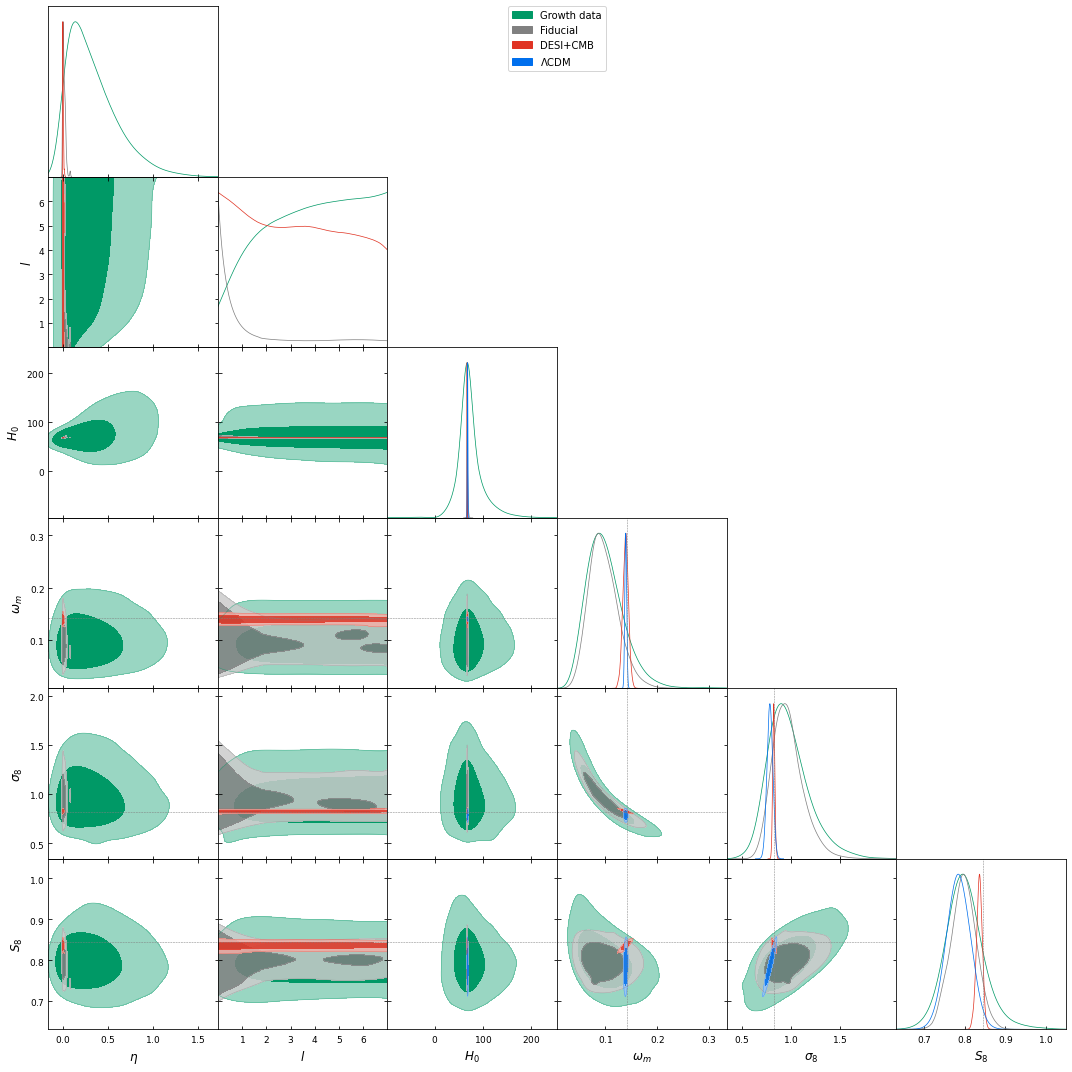

In [42]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_gro_samples, All_CMB_samples, DESI_CMB_samples, LCDM_samples],
                ['n', 'l', 'H0_gp', 'omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

## Data set break down

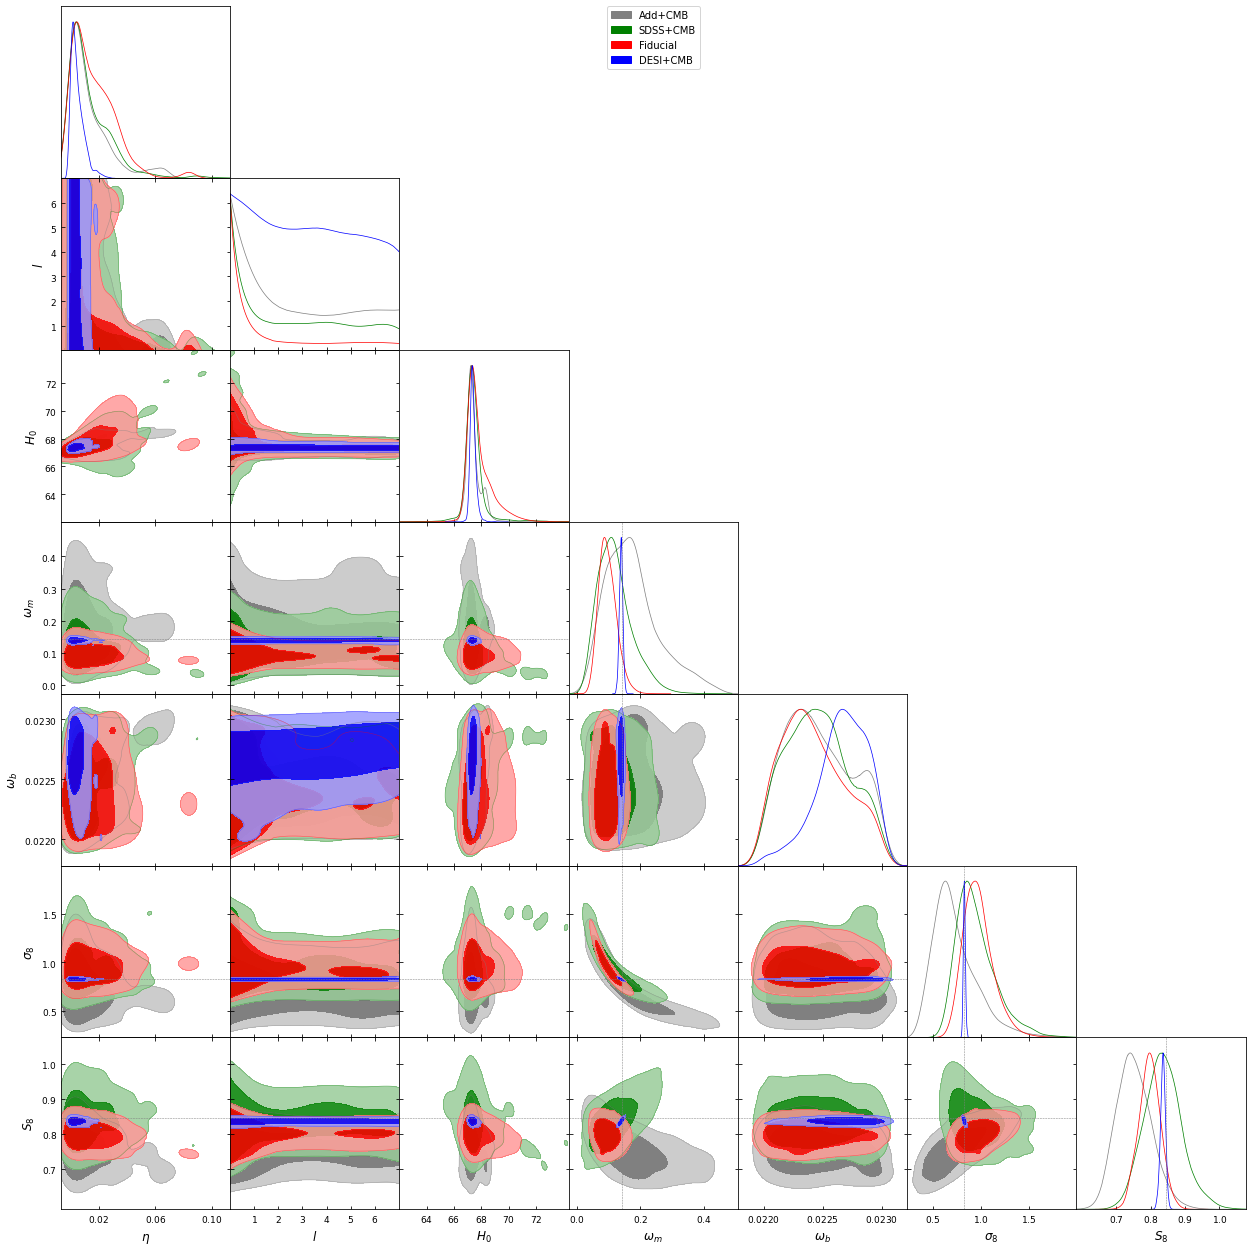

In [43]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([Add_CMB_samples,  SDSS_CMB_samples, All_CMB_samples, DESI_CMB_samples],
                ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                colors = ['grey', 'green', 'red', 'blue'],
                contour_colors = ['grey', 'green', 'red', 'blue'],
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

## Forecasts

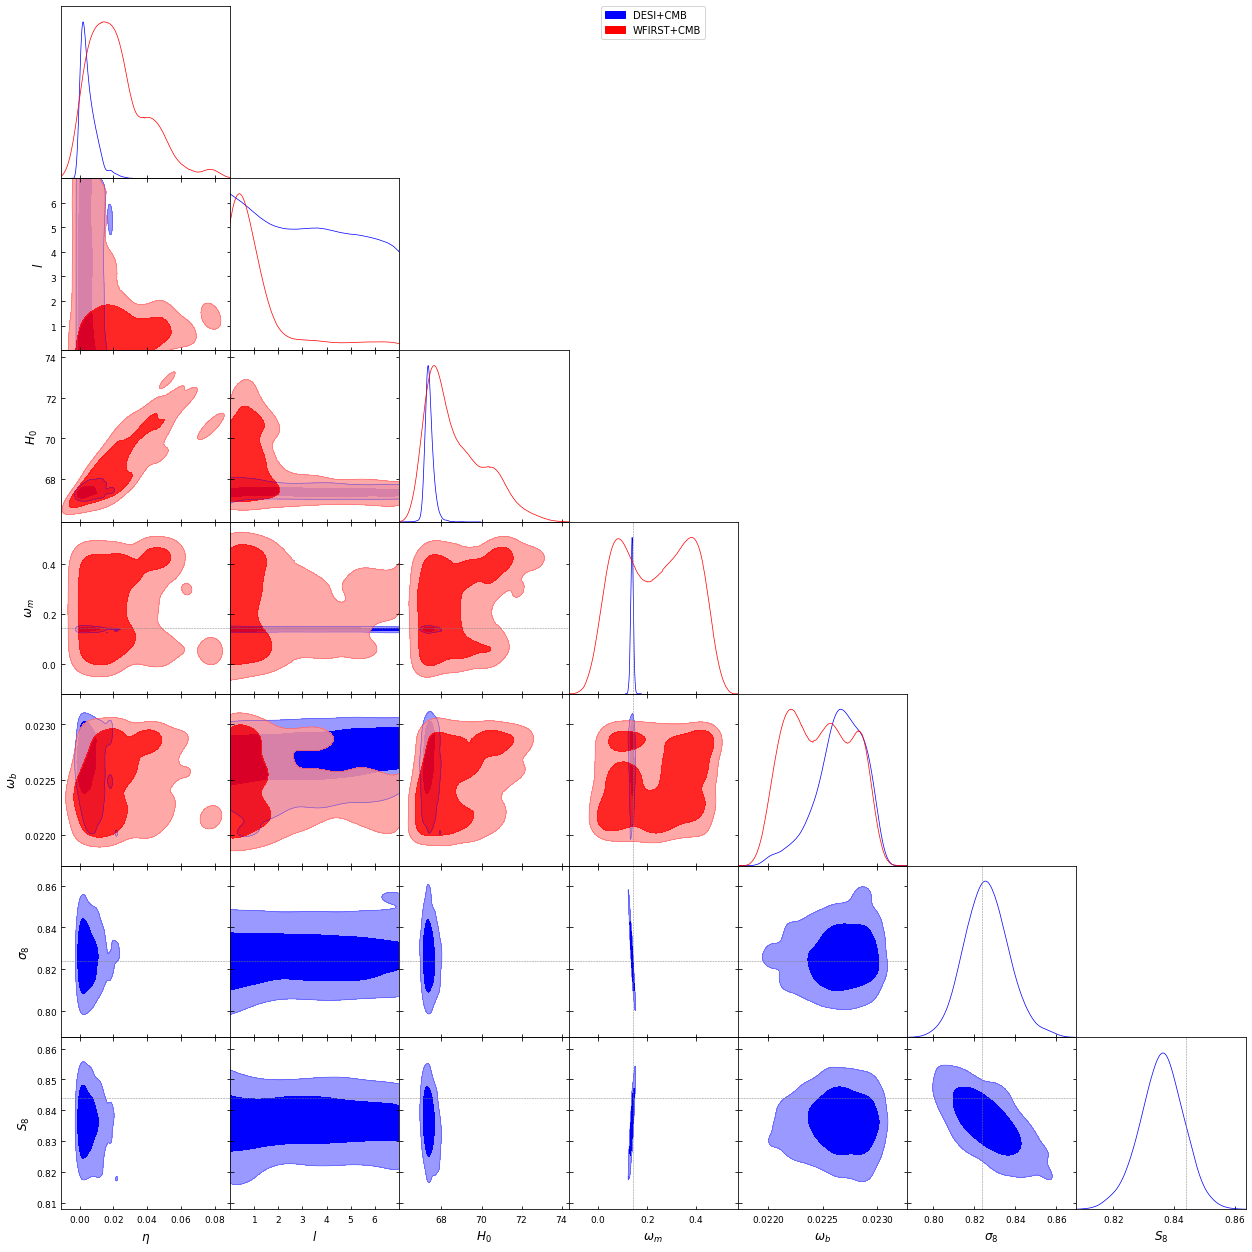

In [44]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_CMB_samples, WFIRST_CMB_samples],
                ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                colors = ['blue', 'red'],
                contour_colors = ['blue', 'red'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_forecast.pdf')

## Alternative

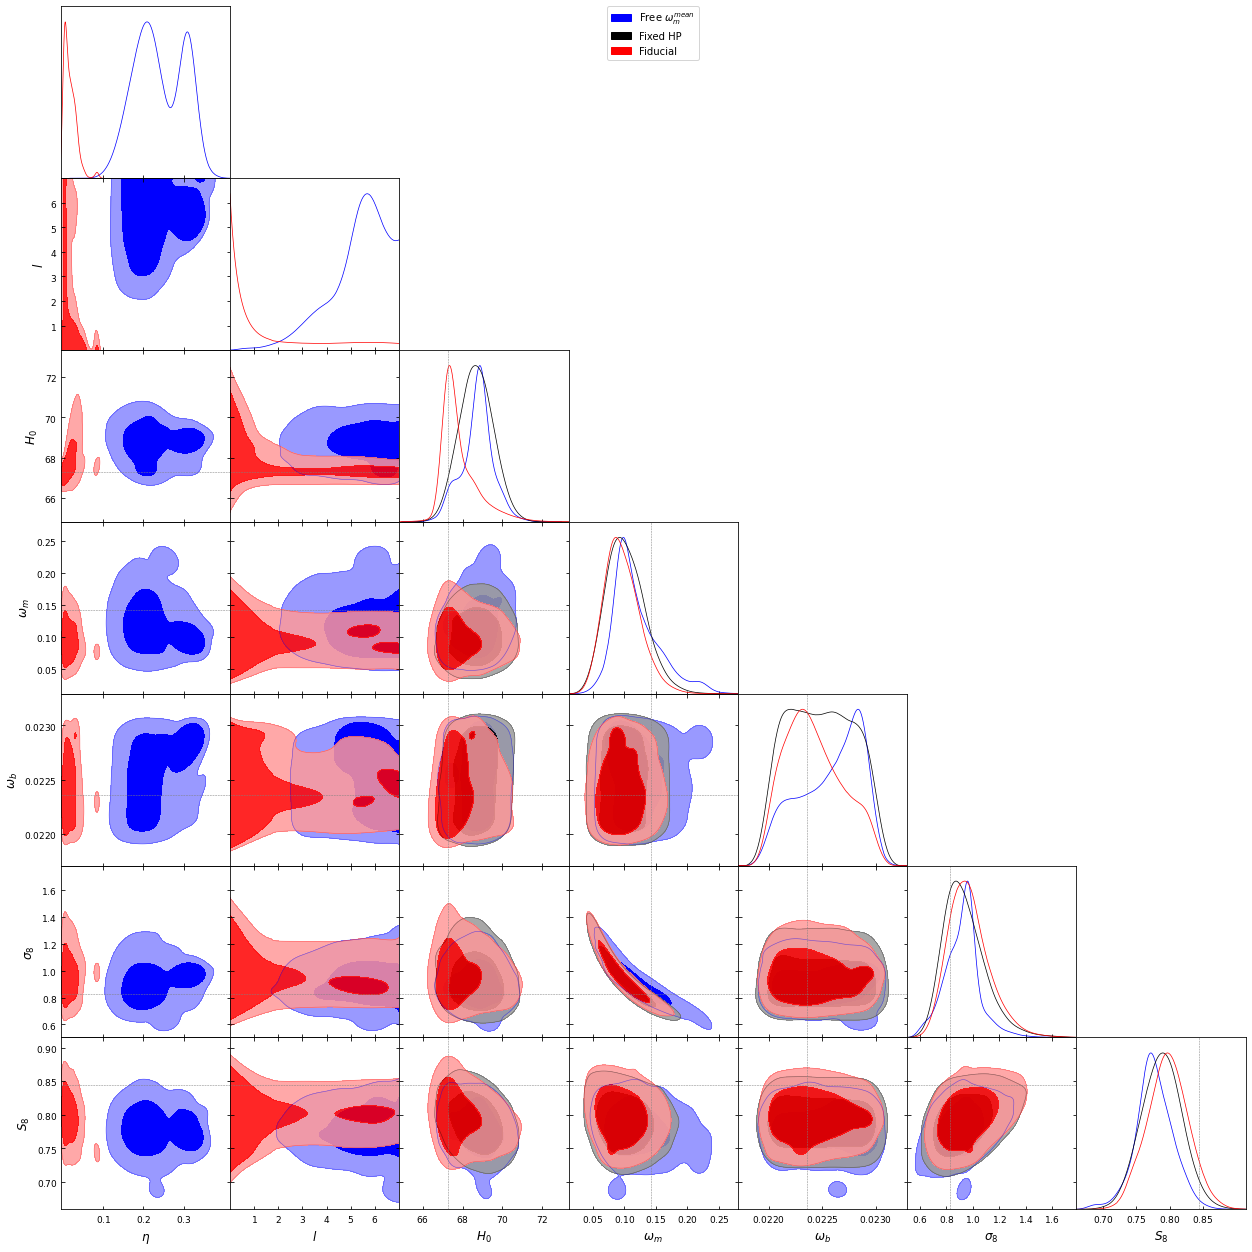

In [45]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([ All_CMB_fm_samples, All_CMB_hp_samples, All_CMB_samples],
                ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                colors = ['blue', 'black',  'red'],
                contour_colors = ['blue', 'black', 'red'],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         'omega_b': data_class.cosmo.Omega_b()*data_class.cosmo.h()**2,
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_tests.pdf')

## Wm vs wm

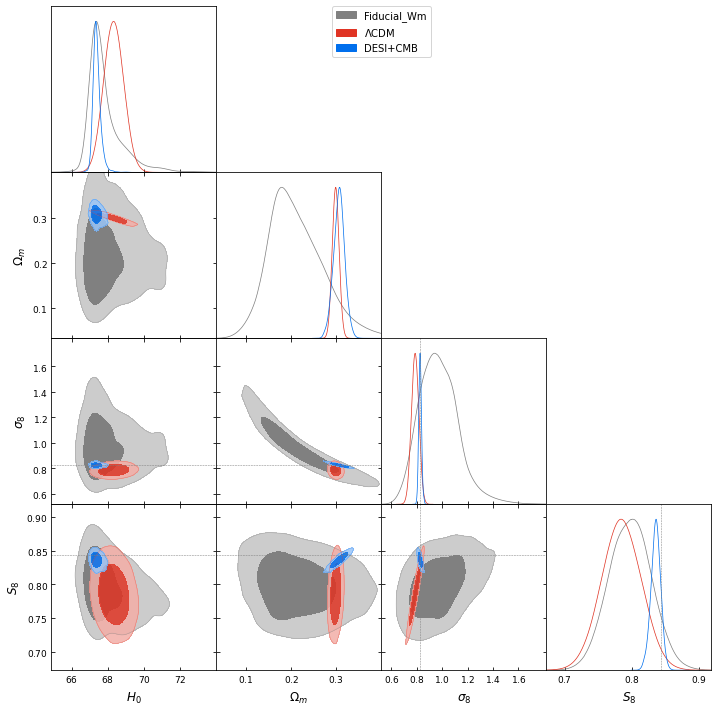

In [46]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_CMB_Wm_samples, LCDM_samples, DESI_CMB_samples],
                ['H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

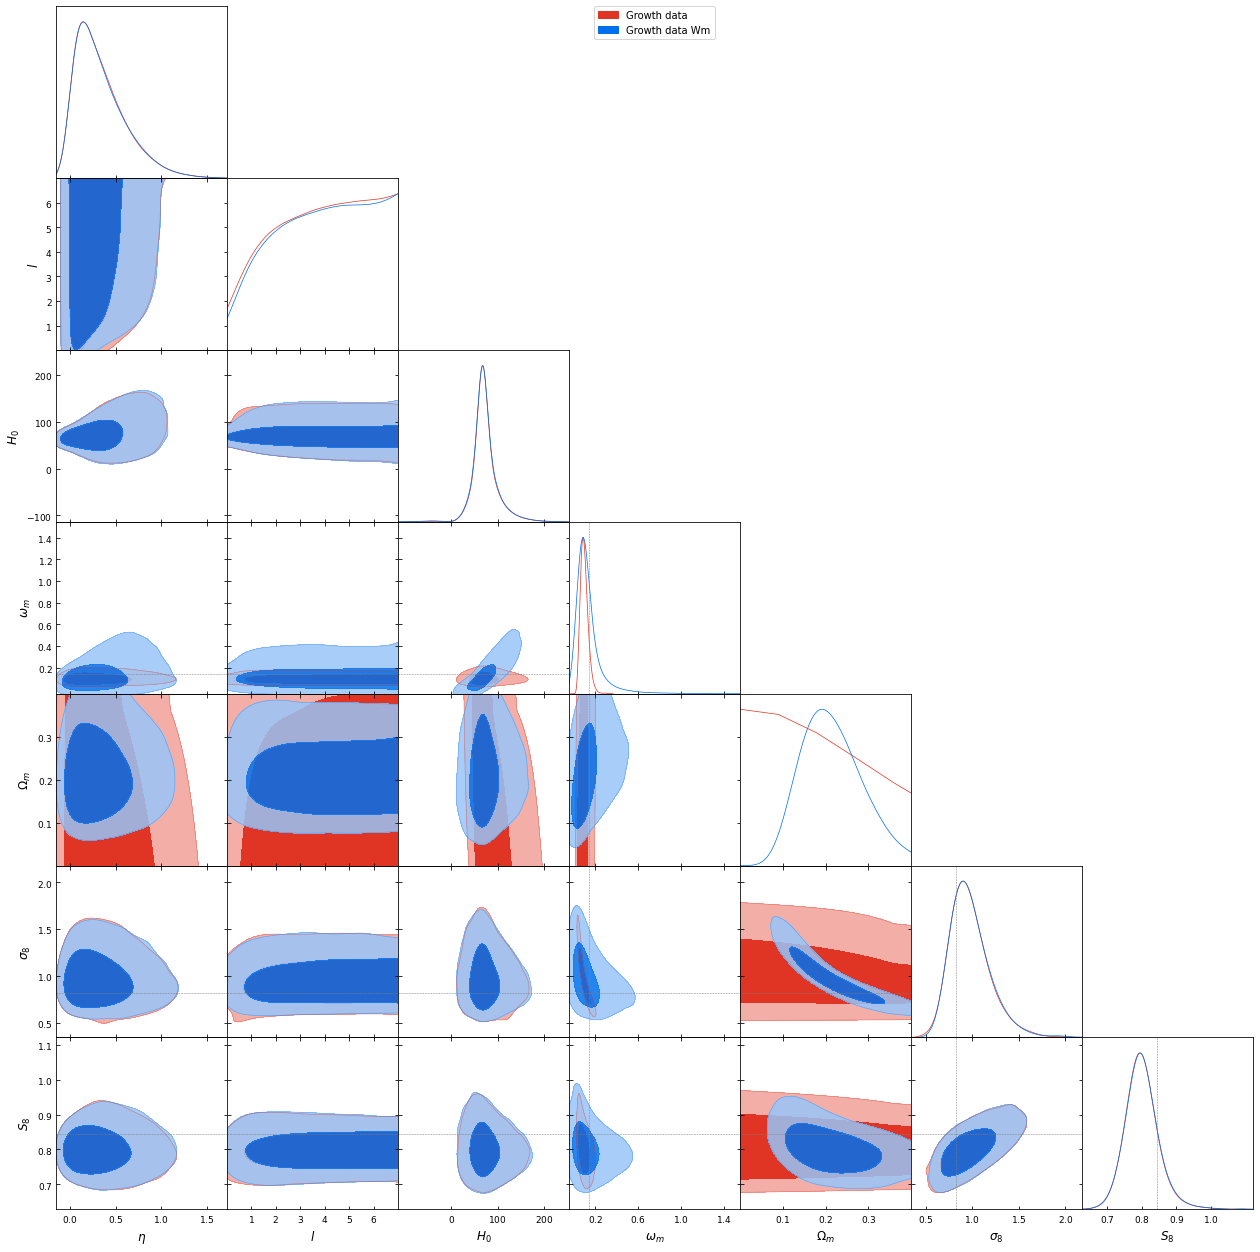

In [33]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_gro_samples, All_gro_Wm_samples],
                ['n', 'l', 'H0_gp', 'omega_m', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

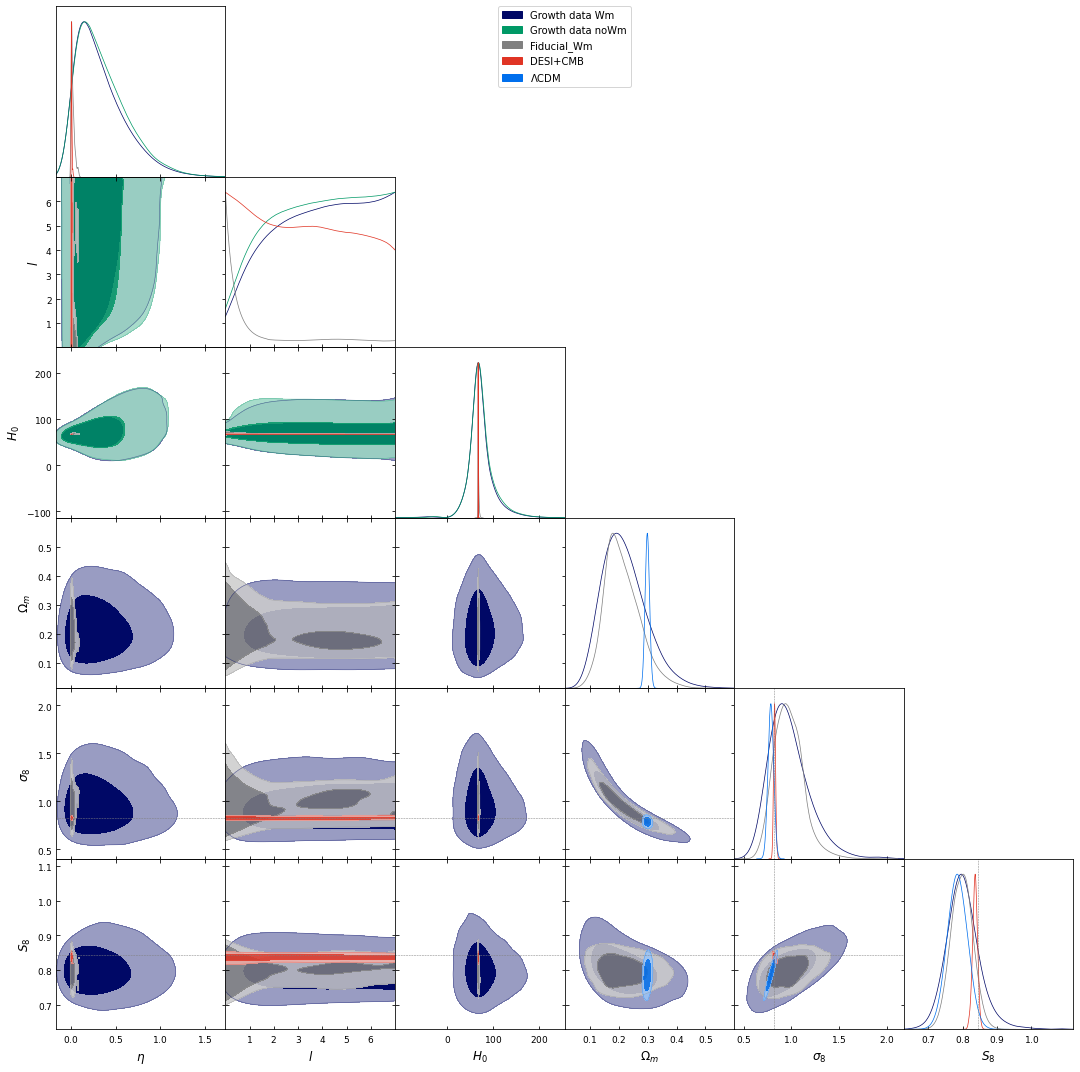

In [40]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_gro_Wm_samples, All_gro_noWm_samples, All_CMB_Wm_samples, DESI_CMB_samples, LCDM_samples],
                ['n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                

## Extra plots

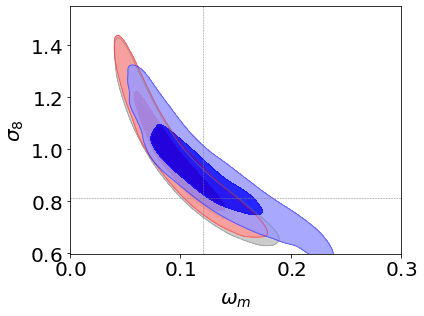

In [31]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_2d([All_CMB_hp_samples,  All_CMB_samples, All_CMB_fm_samples],
          'omega_m', 's80', filled=True,
          colors = ['grey', 'red', 'blue'],
          lims=[0, 0.3, 0.6, 1.55])
g.add_x_marker(0.1202)
g.add_y_marker(0.8120)

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/banana_test.pdf')

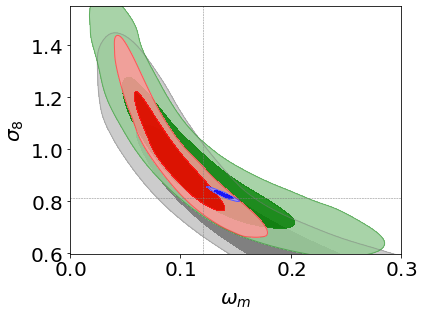

In [20]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_2d([Add_CMB_samples, SDSS_CMB_samples, All_CMB_samples, DESI_CMB_samples],
          'omega_m', 's80', filled=True, 
           colors = ['grey','green', 'red', 'blue'],
           lims=[0, 0.3, 0.6, 1.55], 
           markers={'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                    's80': data_class.cosmo.sigma8()})
g.add_x_marker(0.1202)
g.add_y_marker(0.8120)

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/banana_data.pdf')

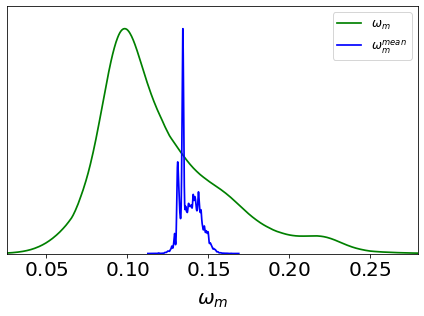

In [23]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_1d([All_CMB_fm_samples, All_CMB_wmean_samples],'omega_m', 
          colors=['green', 'blue'])
g.add_legend([r'$\omega_m$', r'$\omega_m^{mean}$'])
             
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/geovsgro_1D.pdf')

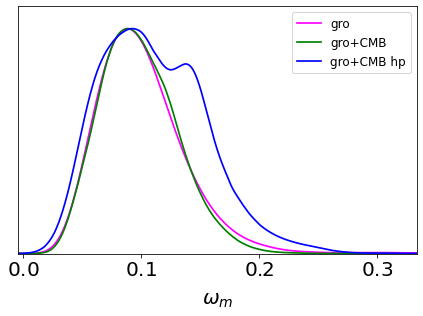

In [24]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_1d([All_gro_samples, All_CMB_gro_samples, All_CMB_gro_hp_samples],'omega_m', 
          colors=['magenta', 'green', 'blue'])
g.add_legend(['gro', 'gro+CMB', 'gro+CMB hp'])
             
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/geovsgro_1D.pdf')

## Challenge

In [55]:
from os import listdir
from os.path import isfile, join
path = '/home/jaimerz/PhD/Growz/data/outputs/challenge/cosmo1'
folders = [f for f in listdir(path) if not isfile(join(path, f))]
folders 

['All_CMB_cosmo10_10000_10000',
 'All_CMB_cosmo11_10000_10000',
 'All_CMB_cosmo12_10000_10000',
 'All_CMB_cosmo13_10000_10000',
 'All_CMB_cosmo14_10000_10000']

In [54]:
path = '/home/jaimerz/PhD/Growz/data/outputs/challenge/'
os.path.join('path', 'cosmo1')

'path/cosmo1'

In [60]:
def challenge_1(cosmo):
    base_path = os.path.join('/home/jaimerz/PhD/Growz/data/outputs/challenge/', cosmo)
    challenges = [f for f in listdir(base_path) if not isfile(join(base_path, f))]
    challenge_samples = []
    for challenge in challenges:
        path = os.path.join(base_path, challenge)+'/samples.npz'
        chain = np.load(path)
        samples = make_samples(chain, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, challenge)
        challenge_samples.append(samples)
    g = plots.getSubplotPlotter(subplot_size=2.5)
    g.triangle_plot(challenge_samples,
                ['H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                contour_colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})              
    g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')
    return  

In [111]:
def challenge_2():
    cosmos = ['cosmo1', 'cosmo2', 'cosmo3', 'cosmo4', 'cosmo5']
    challenge_samples = []
    for cosmo in cosmos:
        base_path = os.path.join('/home/jaimerz/PhD/Growz/data/outputs/challenge/', cosmo)
        challenges = [f for f in listdir(base_path) if not isfile(join(base_path, f))]
        chains = []
        for challenge in challenges:
            path = os.path.join(base_path, challenge)+'/samples.npz'
            chain = np.load(path)
            if '30000' in challenge:
                pass
            else:
                chains.append(chain)
        samples = make_samples_avg(chains, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, cosmo)
        challenge_samples.append(samples)
    g = plots.getSubplotPlotter(subplot_size=2.5)
    g.triangle_plot(challenge_samples,
                ['H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                contour_colors = ['red', 'grey', 'blue', 'green', 'magenta'],
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                        'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})              
    g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')
    return

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


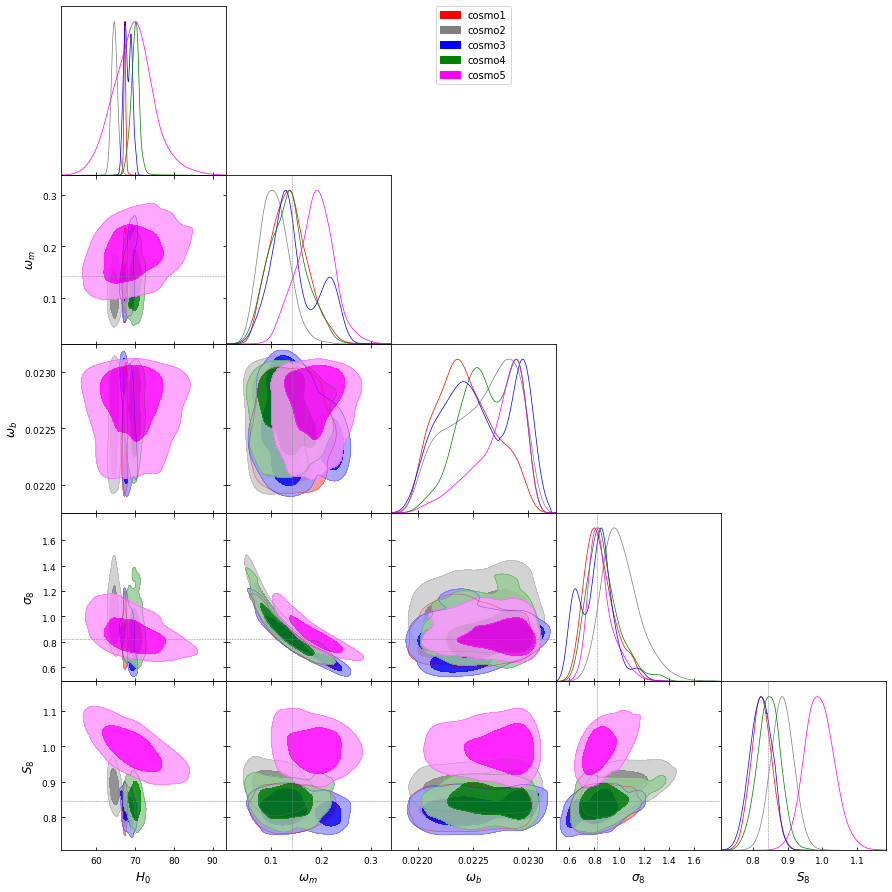

In [112]:
challenge_2()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


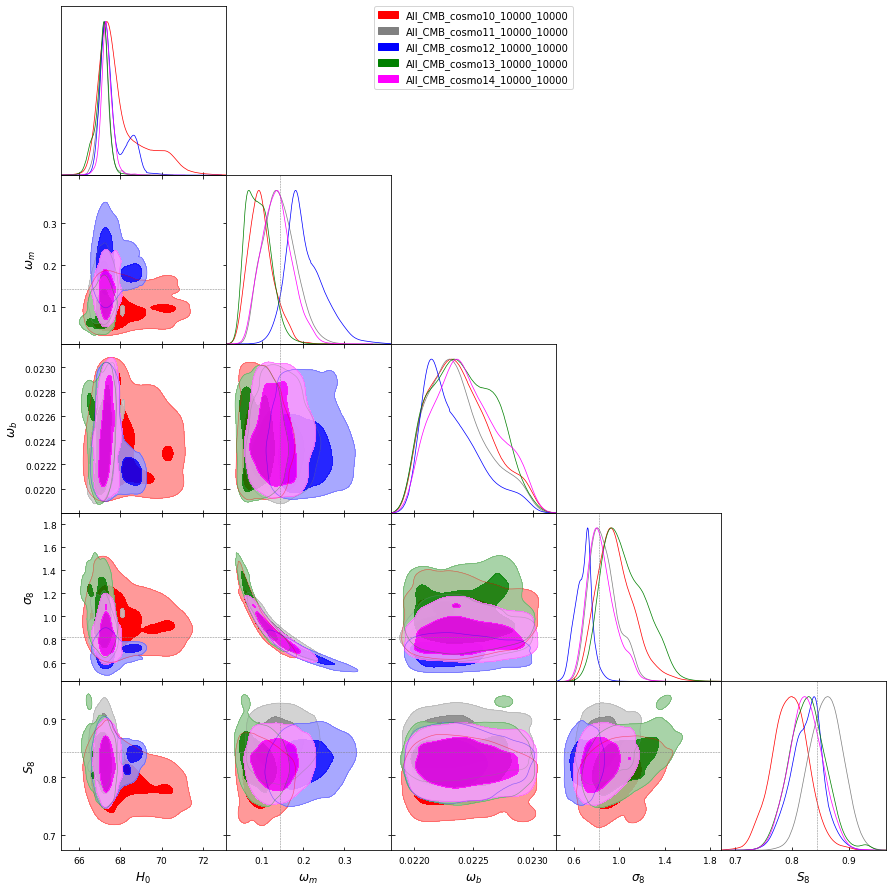

In [94]:
challenge_1('cosmo1')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


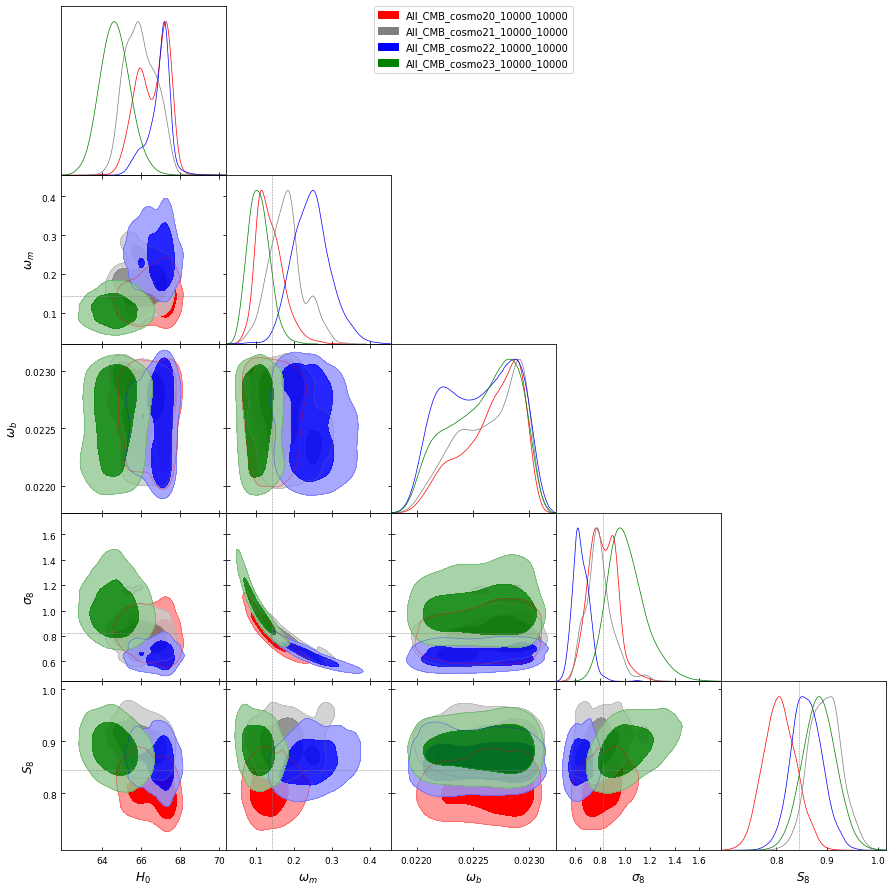

In [95]:
challenge_1('cosmo2')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


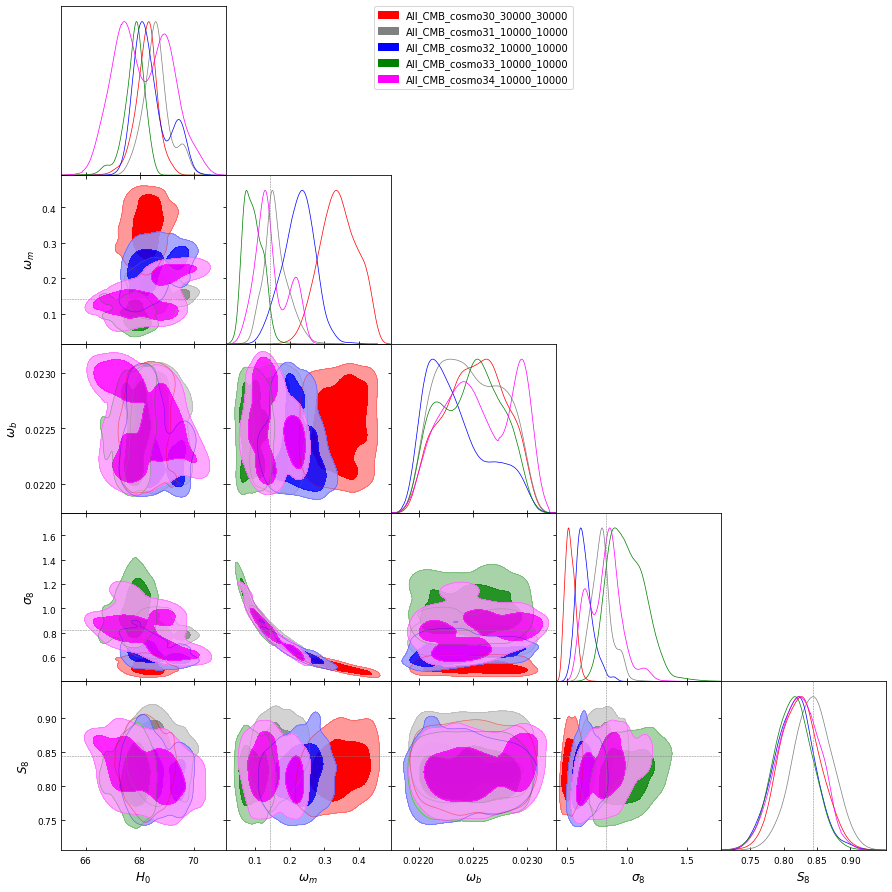

In [96]:
challenge_1('cosmo3')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


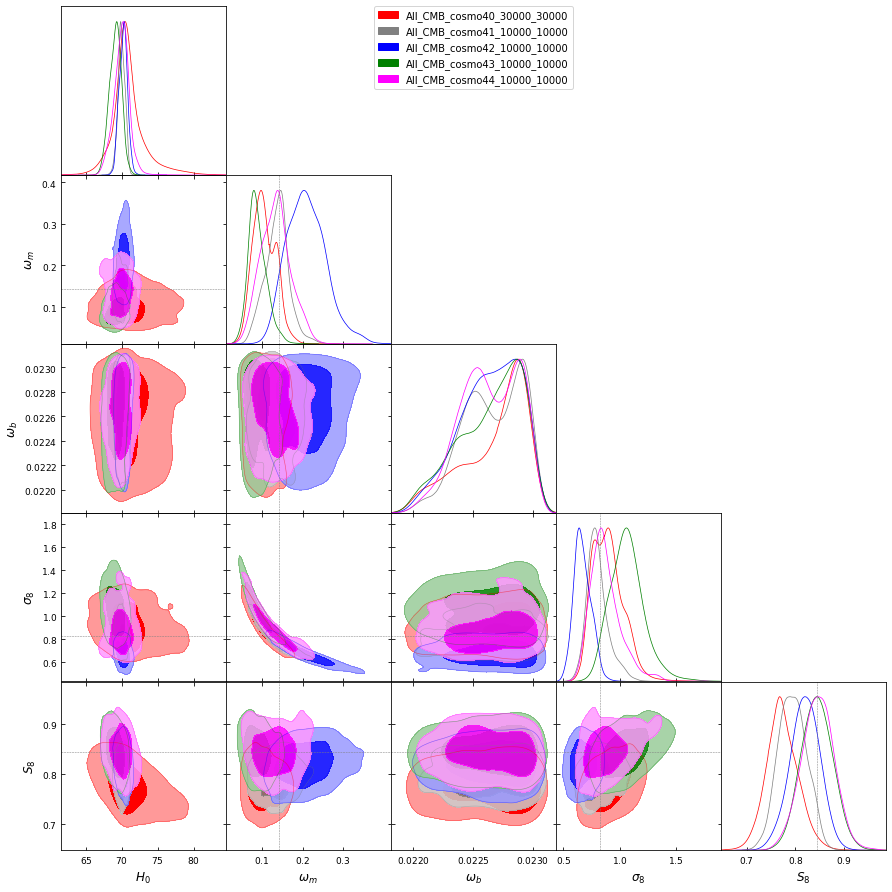

In [97]:
challenge_1('cosmo4')

In [137]:
path = '/home/jaimerz/PhD/Growz/data/outputs/challenge/cosmo4/'
cosmo40 = np.load(path+'All_CMB_cosmo40_30000_30000/samples.npz')
cosmo41 = np.load(path+'All_CMB_cosmo41_10000_10000/samples.npz')
cosmo42 = np.load(path+'All_CMB_cosmo42_10000_10000/samples.npz')
cosmo43 = np.load(path+'All_CMB_cosmo43_10000_10000/samples.npz')
cosmo44 = np.load(path+'All_CMB_cosmo44_10000_10000/samples.npz')
#cosmo41 = np.load(path)
#cosmo42 = np.load(path)
#cosmo43 = np.load(path)
#cosmo44 = np.load(path)

path = '/home/jaimerz/PhD/Growz/data/outputs/challenge/cosmo1/'
cosmo10 = np.load(path+'All_CMB_cosmo10_10000_10000/samples.npz')

In [139]:
#H_cosmo1_m, H_cosmo1_s = get_m_s(cosmo1['Hz'])
H_cosmo1_m, H_cosmo1_s = get_m_s(cosmo10['DHz'])
#H_cosmo2_m, H_cosmo2_s = get_m_s(cosmo2['Hz'])
#H_cosmo3_m, H_cosmo3_s = get_m_s(cosmo3['Hz'])
#H_cosmo3b_m, H_cosmo3b_s = get_m_s(cosmo3b['Hz'])
H_cosmo40_m, H_cosmo40_s = get_m_s(cosmo40['DHz'])
H_cosmo41_m, H_cosmo41_s = get_m_s(cosmo41['DHz'])
H_cosmo42_m, H_cosmo42_s = get_m_s(cosmo42['DHz'])
H_cosmo43_m, H_cosmo43_s = get_m_s(cosmo43['DHz'])
H_cosmo44_m, H_cosmo44_s = get_m_s(cosmo44['DHz'])
#H_cosmo4b_m, H_cosmo4b_s = get_m_s(cosmo4b['Hz'])
#H_cosmo5_m, H_cosmo5_s = get_m_s(cosmo5['Hz'])


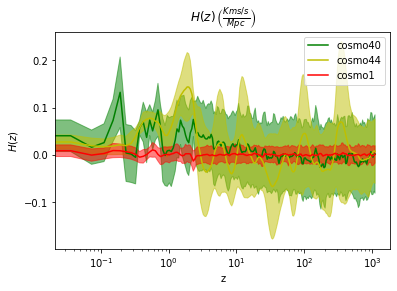

In [145]:
plt.plot(z_arr,  H_cosmo40_m, color ='g', label='cosmo40')
plt.fill_between(z_arr, H_cosmo40_m+H_cosmo40_s,
                 H_cosmo40_m-H_cosmo40_s, color='g', alpha=.5)

#plt.plot(z_arr,  H_cosmo41_m, color ='k', label='cosmo41')
#plt.fill_between(z_arr, H_cosmo41_m+H_cosmo41_s,
#                 H_cosmo41_m-H_cosmo41_s, color='k', alpha=.5)

#plt.plot(z_arr,  H_cosmo42_m, color ='b', label='cosmo42')
#plt.fill_between(z_arr, H_cosmo42_m+H_cosmo42_s,
#                 H_cosmo42_m-H_cosmo42_s, color='b', alpha=.5)

#plt.plot(z_arr,  H_cosmo43_m, color ='m', label='cosmo43')
#plt.fill_between(z_arr, H_cosmo43_m+H_cosmo43_s,
#                 H_cosmo43_m-H_cosmo43_s, color='m', alpha=.5)

plt.plot(z_arr,  H_cosmo44_m, color ='y', label='cosmo44')
plt.fill_between(z_arr, H_cosmo44_m+H_cosmo44_s,
                 H_cosmo44_m-H_cosmo44_s, color='y', alpha=.5)

plt.plot(z_arr,  H_cosmo1_m, color ='r', label='cosmo1')
plt.fill_between(z_arr, H_cosmo1_m+H_cosmo1_s,
                 H_cosmo1_m-H_cosmo1_s, color='r', alpha=.5)

#plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')


#plt.xlim(0, 2.5)
#plt.ylim(50, 300)
plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


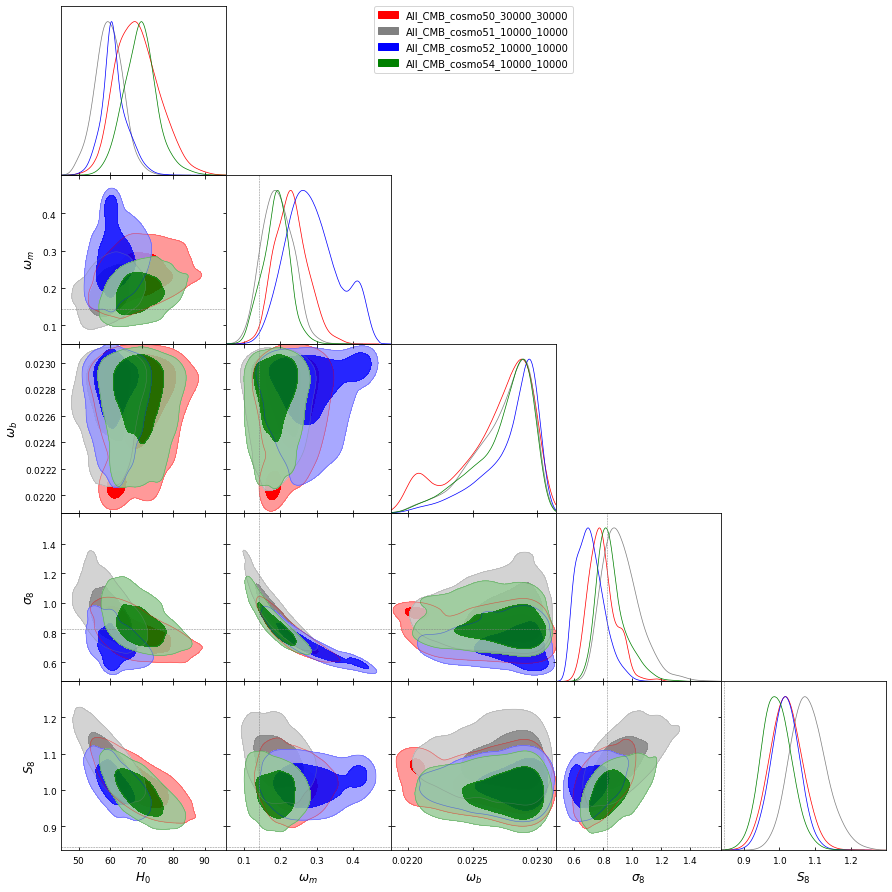

In [98]:
challenge_1('cosmo5')

cosmo1
H0 68.02998972501466 +/- 1.146292106197964
S80 0.7970290170509826 +/- 0.03133758297413431
s80 0.9708776173571869 +/- 0.1622469811918684
wm0 0.09804462762839708 +/- 0.029594203084593047
-----
cosmo2
H0 66.5760090505596 +/- 0.7871825685427813
S80 0.8072532634964323 +/- 0.03113719899057822
s80 0.8219409988047444 +/- 0.10807050018817857
wm0 0.1370253275552228 +/- 0.03500111187671322
-----
cosmo3
H0 68.25197847157615 +/- 0.4125542515478483
S80 0.8250079339215485 +/- 0.029691691241644457
s80 0.5243011614014008 +/- 0.04109122391673338
wm0 0.34126491596130604 +/- 0.051615385929372586
-----
cosmo3b
H0 68.63967934167721 +/- 0.4978472650999041
S80 0.8435219784102048 +/- 0.02917926042729548
s80 0.7870740972032123 +/- 0.08528093908830435
wm0 0.16091424450718422 +/- 0.03459074399990212
-----
cosmo4
H0 70.93792300886885 +/- 2.3666164726747208
S80 0.7732876395485039 +/- 0.03178558289520174
s80 0.8980822007890866 +/- 0.13473850888146377
wm0 0.10606958552368338 +/- 0.027316106148437325
-----
cosm

# d_H gp 

In [ ]:
dH_DESI_CMB_m, dH_DESI_CMB_s = get_m_s(DESI_CMB['DHz'])
dH_DESI_gro_m, dH_DESI_gro_s = get_m_s(DESI_gro['DHz'])
dH_DESI_CMB_geo_m, dH_DESI_CMB_geo_s = get_m_s(DESI_CMB_geo['DHz'])
dH_WFIRST_CMB_m, dH_WFIRST_CMB_s = get_m_s(WFIRST_CMB['DHz'])
dH_All_m, dH_All_s = get_m_s(All['DHz'])
dH_All_gro_m, dH_All_gro_s = get_m_s(All_gro['DHz'])
dH_All_gro_Wm_m, dH_All_gro_Wm_s = get_m_s(All_gro_Wm['DHz'])
dH_All_gro_noWm_m, dH_All_gro_noWm_s = get_m_s(All_gro_noWm['DHz'])
dH_All_gro_nowm_m, dH_All_gro_nowm_s = get_m_s(All_gro_nowm['DHz'])
dH_All_CMB_m, dH_All_CMB_s = get_m_s(All_CMB['DHz'])
dH_All_CMB_Wm_m, dH_All_CMB_Wm_s = get_m_s(All_CMB_Wm['DHz'])
dH_All_CMB_nowm_m, dH_All_CMB_nowm_s = get_m_s(All_CMB_nowm['DHz'])
dH_All_CMB_hp_m, dH_All_CMB_hp_s = get_m_s(All_CMB_hp['DHz'])
dH_All_CMB_fm_m, dH_All_CMB_fm_s = get_m_s(All_CMB_fm['DHz'])
dH_All_CMB_geo_m, dH_All_CMB_geo_s = get_m_s(All_CMB_geo['DHz'])
dH_All_CMB_gro_m, dH_All_CMB_gro_s = get_m_s(All_CMB_gro['DHz'])
dH_All_CMB_gro_hp_m, dH_All_CMB_gro_hp_s = get_m_s(All_CMB_gro_hp['DHz'])
dH_All_CMB_geo_hp_m, dH_All_CMB_geo_hp_s = get_m_s(All_CMB_geo_hp['DHz'])
dH_All_CMB_Xi_full_m, dH_All_CMB_Xi_full_s = get_m_s(All_CMB_Xi_full['DHz'])
dH_SDSS_m, dH_SDSS_s = get_m_s(SDSS['DHz'])
dH_SDSS_CMB_m, dH_SDSS_CMB_s = get_m_s(SDSS_CMB['DHz'])
dH_Add_m, dH_Add_s = get_m_s(Add['DHz'])
dH_Add_CMB_m, dH_Add_CMB_s = get_m_s(Add_CMB['DHz'])

dH_cosmo1_m, dH_cosmo1_s = get_m_s(cosmo1['DHz'])
dH_cosmo2_m, dH_cosmo2_s = get_m_s(cosmo2['DHz'])
dH_cosmo3_m, dH_cosmo3_s = get_m_s(cosmo3['DHz'])
dH_cosmo3b_m, dH_cosmo3b_s = get_m_s(cosmo3b['DHz'])
dH_cosmo4_m, dH_cosmo4_s = get_m_s(cosmo4['DHz'])
dH_cosmo4b_m, dH_cosmo4b_s = get_m_s(cosmo4b['DHz'])
dH_cosmo5_m, dH_cosmo5_s = get_m_s(cosmo5['DHz'])

Planck = data_class.Planck
z_planck = data_class.z_planck

In [ ]:
plt.plot(z_arr,  dH_cosmo1_m, color ='r', label='cosmo1')
plt.fill_between(z_arr, dH_cosmo1_m+dH_cosmo1_s,
                 dH_cosmo1_m-dH_cosmo1_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_cosmo2_m, color ='k', label='cosmo2')
plt.fill_between(z_arr, dH_cosmo2_m+dH_cosmo2_s,
                 dH_cosmo2_m-dH_cosmo2_s, color='k', alpha=.5)

plt.plot(z_arr,  dH_cosmo3_m, color ='b', label='cosmo3')
plt.fill_between(z_arr, dH_cosmo3_m+dH_cosmo3_s,
                 dH_cosmo3_m-dH_cosmo3_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_cosmo4_m, color ='g', label='cosmo4')
plt.fill_between(z_arr, dH_cosmo4_m+dH_cosmo4_s,
                 dH_cosmo4_m-dH_cosmo4_s, color='g', alpha=.5)

plt.plot(z_arr,  dH_cosmo5_m, color ='m', label='cosmo5')
plt.fill_between(z_arr, dH_cosmo4_m+dH_cosmo4_s,
                 dH_cosmo5_m-dH_cosmo5_s, color='m', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')  

In [ ]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_hp_m, color ='k', label='Fixed HP')
plt.fill_between(z_arr, dH_All_CMB_hp_m+dH_All_CMB_hp_s,
                 dH_All_CMB_hp_m-dH_All_CMB_hp_s, color='k', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_fm_m, color ='b', label='Free $\omega_m^{mean}$')
plt.fill_between(z_arr, dH_All_CMB_fm_m+dH_All_CMB_fm_s,
                 dH_All_CMB_fm_m-dH_All_CMB_fm_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')  

In [ ]:
plt.plot(z_arr,  dH_All_CMB_Xi_full_m, color ='b', label='$H_{gp}+\Xi_{gp}$')
plt.fill_between(z_arr, dH_All_CMB_Xi_full_m+dH_All_CMB_Xi_full_s,
                 dH_All_CMB_Xi_full_m-dH_All_CMB_Xi_full_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')
#plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')  

In [ ]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_Add_CMB_m, color ='k', label='Add+CMB')
plt.fill_between(z_arr, dH_Add_CMB_m+dH_Add_CMB_s,
                 dH_Add_CMB_m-dH_Add_CMB_s, color='k', alpha=.5)

plt.plot(z_arr,  dH_SDSS_CMB_m, color ='g', label='SDSS+CMB')
plt.fill_between(z_arr, dH_SDSS_CMB_m+dH_SDSS_CMB_s,
                 dH_SDSS_CMB_m-dH_SDSS_CMB_s, color='gk', alpha=.5)

#plt.plot(z_arr,  dH_DESI_CMB_m, color ='b', label='DESI_CMB')
#plt.fill_between(z_arr, dH_DESI_CMB_m+dH_DESI_CMB_s,
#                 dH_DESI_CMB_m-dH_DESI_CMB_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_data.pdf')  

In [ ]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_m, color ='b', label='Fiducial - CMB')
plt.fill_between(z_arr, dH_All_m+dH_All_s,
                 dH_All_m-dH_All_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_All_gro_m, color ='m', label='Growth data')
plt.fill_between(z_arr, dH_All_gro_m+dH_All_gro_s,
                 dH_All_gro_m-dH_All_gro_s, color='m', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo_m, color ='g', label='Geometry data')
plt.fill_between(z_arr, dH_All_CMB_geo_m+dH_All_CMB_geo_s,
                 dH_All_CMB_geo_m-dH_All_CMB_geo_s, color='g', alpha=.5)

#plt.plot(z_arr,  dH_All_CMB_gro_m, color ='b', label='All_CMB_gro')
#plt.fill_between(z_arr, dH_All_CMB_gro_m+dH_All_CMB_gro_s,
#                 dH_All_CMB_gro_m-dH_All_CMB_gro_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
#plt.ylim(-.04, .04)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend(loc='lower left')

axes = plt.axes([0.62, 0.5, 0.5, 0.5])
axes.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
axes.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)
axes.plot(z_arr,  dH_All_CMB_geo_m, color ='g', label='Geometry data')
axes.fill_between(z_arr, dH_All_CMB_geo_m+dH_All_CMB_geo_s,
                 dH_All_CMB_geo_m-dH_All_CMB_geo_s, color='g', alpha=.5)
plt.xscale('log')
plt.xlim(0, 1100)

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf')  

In [ ]:
plt.plot(z_arr,  dH_All_CMB_Wm_m, color ='r', label='Fiducial_Wm')
plt.fill_between(z_arr, dH_All_CMB_Wm_m+dH_All_CMB_Wm_s,
                 dH_All_CMB_Wm_m-dH_All_CMB_Wm_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_gro_Wm_m, color ='m', label='Growth data_Wm')
plt.fill_between(z_arr, dH_All_gro_Wm_m+dH_All_gro_Wm_s,
                 dH_All_gro_Wm_m-dH_All_gro_Wm_s, color='m', alpha=.5)

plt.plot(z_arr,  dH_All_gro_noWm_m, color ='b', label='Growth data_noWm')
plt.fill_between(z_arr, dH_All_gro_noWm_m+dH_All_gro_noWm_s,
                 dH_All_gro_noWm_m-dH_All_gro_noWm_s, color='b', alpha=.5)

#plt.plot(z_arr,  dH_All_CMB_gro_m, color ='b', label='All_CMB_gro')
#plt.fill_between(z_arr, dH_All_CMB_gro_m+dH_All_CMB_gro_s,
#                 dH_All_CMB_gro_m-dH_All_CMB_gro_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
#plt.ylim(-.04, .04)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend(loc='lower left')

axes = plt.axes([0.62, 0.5, 0.5, 0.5])
axes.plot(z_arr,  dH_All_CMB_Wm_m, color ='r', label='Fiducial_Wm')
axes.fill_between(z_arr, dH_All_CMB_Wm_m+dH_All_CMB_Wm_s,
                 dH_All_CMB_Wm_m-dH_All_CMB_Wm_s, color='r', alpha=.5)

plt.xscale('log')
plt.xlim(0, 1100)

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf')  

<ipython-input-39-7121879a68ec>:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


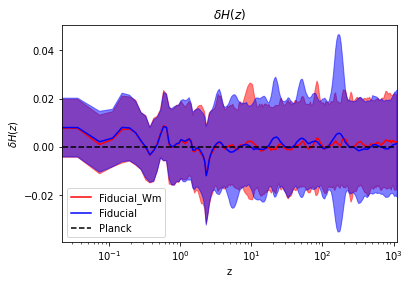

In [39]:
plt.plot(z_arr,  dH_All_CMB_Wm_m, color ='r', label='Fiducial_Wm')
plt.fill_between(z_arr, dH_All_CMB_Wm_m+dH_All_CMB_Wm_s,
                 dH_All_CMB_Wm_m-dH_All_CMB_Wm_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_m, color ='b', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
#plt.ylim(-.04, .04)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend(loc='lower left')

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_geo_vs_gro.pdf')  

In [ ]:
plt.fig

plt.plot(z_arr,  dH_All_gro_nowm_m, color ='g', label='Growth data + fixed $\omega_m$')
plt.fill_between(z_arr, dH_All_gro_nowm_m+dH_All_gro_nowm_s,
                 dH_All_gro_nowm_m-dH_All_gro_nowm_s, color='g', alpha=.5)

plt.plot(z_arr,  dH_All_gro_m, color ='m', label='Growth data')
plt.fill_between(z_arr, dH_All_gro_m+dH_All_gro_s,
                 dH_All_gro_m-dH_All_gro_s, color='m', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_nowm_m, color ='b', label='Fiducial + Fixed $\omega_m$')
plt.fill_between(z_arr, dH_All_CMB_nowm_m+dH_All_CMB_nowm_s,
                 dH_All_CMB_nowm_m-dH_All_CMB_nowm_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend(loc='lower left')

axes = plt.axes([0.62, 0.5, 0.5, 0.5])
axes.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
axes.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)
axes.plot(z_arr,  dH_All_CMB_nowm_m, color ='b', label='Fiducial + Fixed $\omega_m$')
axes.fill_between(z_arr, dH_All_CMB_nowm_m+dH_All_CMB_nowm_s,
                 dH_All_CMB_nowm_m-dH_All_CMB_nowm_s, color='b', alpha=.5)

plt.xscale('log')
plt.xlim(0, 1100)


os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_fixed_wm.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_fixed_wm.pdf')  

In [ ]:
plt.plot(z_arr,  dH_All_CMB_gro_hp_m, color ='b', label='All_CMB_gro_hp')
plt.fill_between(z_arr, dH_All_CMB_gro_hp_m+dH_All_CMB_gro_hp_s,
                 dH_All_CMB_gro_hp_m-dH_All_CMB_gro_hp_s, color='b', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_hp_m, color ='r', label='All_CMB_hp')
plt.fill_between(z_arr, dH_All_CMB_hp_m+dH_All_CMB_hp_s,
                 dH_All_CMB_hp_m-dH_All_CMB_hp_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo_hp_m, color ='g', label='All_CMB_geo_hp')
plt.fill_between(z_arr, dH_All_CMB_geo_hp_m+dH_All_CMB_geo_hp_s,
                 dH_All_CMB_geo_hp_m-dH_All_CMB_geo_hp_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z)$")
plt.legend();


In [ ]:
print('Geo+Gro: ', np.mean(dH_All_CMB_s), '+/-', np.std(dH_All_CMB_s))
print('No cmb: ', np.mean(dH_All_s), '+/-', np.std(dH_All_s))
print('Geo: ', np.mean(dH_All_CMB_geo_s), '+/-', np.std(dH_All_CMB_geo_s))
print('Gro: ', np.mean(dH_All_gro_s), '+/-', np.std(dH_All_gro_s))
print('Fixed wm: ', np.mean(dH_All_CMB_nowm_s), '+/-', np.std(dH_All_CMB_nowm_s))
print('Gro Fixed wm: ', np.mean(dH_All_gro_nowm_s), '+/-', np.std(dH_All_gro_nowm_s))
print('Geo+Gro hp: ', np.mean(dH_All_CMB_hp_s), '+/-', np.std(dH_All_CMB_hp_s))
print('Geo hp:', np.mean(dH_All_CMB_geo_hp_s), '+/-', np.std(dH_All_CMB_geo_hp_s))
print('Gro+CMB hp:', np.mean(dH_All_CMB_gro_hp_s), '+/-', np.std(dH_All_CMB_gro_hp_s))
print('Gro+ fixed wm: ', np.mean(dH_All_gro_nowm_s), '+/-', np.std(dH_All_gro_nowm_s))
print('WFIRST+CMB: ', np.mean(dH_WFIRST_CMB_s), '+/-', np.std(dH_WFIRST_CMB_s))


In [ ]:
plt.plot(z_arr,  np.zeros_like(z_arr), color ='b', label='DESI+CMB')
plt.fill_between(z_arr, np.zeros_like(z_arr)+dH_DESI_CMB_s,
                 np.zeros_like(z_arr)-dH_DESI_CMB_s, color='b', alpha=.5)

#plt.plot(z_arr,  dH_DESI_gro_m, color ='r', label='Only Growth DESI')
#plt.fill_between(z_arr, dH_DESI_gro_m+dH_DESI_gro_s,
#                 dH_DESI_gro_m-dH_DESI_gro_s, color='r', alpha=.5)

plt.plot(z_arr,  np.zeros_like(z_arr), color ='g', label='Only Geometry DESI+CMB')
plt.fill_between(z_arr, np.zeros_like(z_arr)+dH_DESI_CMB_geo_s,
                 np.zeros_like(z_arr)-dH_DESI_CMB_geo_s, color='g', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
print('DESI+CMB: ', np.mean(dH_DESI_CMB_s), '+/-', np.std(dH_DESI_CMB_s))
print('DESI Gro: ', np.mean(dH_DESI_gro_s), '+/-', np.std(dH_DESI_gro_s))
print('DESI+CMB Geo: ', np.mean(dH_DESI_CMB_geo_s), '+/-', np.std(dH_DESI_CMB_geo_s))


In [ ]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_WFIRST_CMB_m, color ='y', label='WFIRST+CMB')
plt.fill_between(z_arr, dH_WFIRST_CMB_m+dH_WFIRST_CMB_s,
                 dH_WFIRST_CMB_m-dH_WFIRST_CMB_s, color='y', alpha=.5)

plt.plot(z_arr,  dH_DESI_CMB_m, color ='b', label='DESI+CMB')
plt.fill_between(z_arr, dH_DESI_CMB_m+dH_DESI_CMB_s,
                 dH_DESI_CMB_m-dH_DESI_CMB_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

In [ ]:
print('Current: ', np.mean(dH_All_CMB_s), '+/-', np.std(dH_All_CMB_s))
print('DESI: ', np.mean(dH_DESI_CMB_s), '+/-', np.std(dH_DESI_CMB_s))
print('WFIRST: ', np.mean(dH_WFIRST_CMB_s), '+/-', np.std(dH_WFIRST_CMB_s))

# H gp 

In [ ]:
H_DESI_m, H_DESI_s = get_m_s(DESI['Hz'])
H_DESI_CMB_m, H_DESI_CMB_s = get_m_s(DESI_CMB['Hz'])
H_WFIRST_CMB_m, H_WFIRST_CMB_s = get_m_s(WFIRST_CMB['Hz'])
H_All_m, H_All_s = get_m_s(All['Hz'])
H_All_CMB_m, H_All_CMB_s = get_m_s(All_CMB['Hz'])
H_All_CMB_hp_m, H_All_CMB_hp_s = get_m_s(All_CMB_hp['Hz'])
H_All_CMB_fm_m, H_All_CMB_fm_s = get_m_s(All_CMB_fm['Hz'])
H_All_CMB_geo_m, H_All_CMB_geo_s = get_m_s(All_CMB_geo['Hz'])
H_All_CMB_gro_m, H_All_CMB_gro_s = get_m_s(All_CMB_gro['Hz'])
H_All_CMB_Xi_full_m, H_All_CMB_Xi_full_s = get_m_s(All_CMB_Xi_full['Hz'])
H_SDSS_m, H_SDSS_s = get_m_s(SDSS['Hz'])
H_SDSS_CMB_m, H_SDSS_CMB_s = get_m_s(SDSS_CMB['Hz'])
H_Add_m, H_Add_s = get_m_s(Add['Hz'])
H_Add_CMB_m, H_Add_CMB_s = get_m_s(Add_CMB['Hz'])

H_cosmo1_m, H_cosmo1_s = get_m_s(cosmo1['Hz'])
H_cosmo2_m, H_cosmo2_s = get_m_s(cosmo2['Hz'])
H_cosmo3_m, H_cosmo3_s = get_m_s(cosmo3['Hz'])
H_cosmo3b_m, H_cosmo3b_s = get_m_s(cosmo3b['Hz'])
H_cosmo4_m, H_cosmo4_s = get_m_s(cosmo4['Hz'])
H_cosmo4b_m, H_cosmo4b_s = get_m_s(cosmo4b['Hz'])
H_cosmo5_m, H_cosmo5_s = get_m_s(cosmo5['Hz'])

In [ ]:
plt.plot(z_arr,  H_cosmo1_m, color ='r', label='cosmo1')
plt.fill_between(z_arr, H_cosmo1_m+H_cosmo1_s,
                 H_cosmo1_m-H_cosmo1_s, color='r', alpha=.5)

plt.plot(z_arr,  H_cosmo2_m, color ='k', label='cosmo2')
plt.fill_between(z_arr, H_cosmo2_m+H_cosmo2_s,
                 H_cosmo2_m-H_cosmo2_s, color='k', alpha=.5)

plt.plot(z_arr,  H_cosmo3_m, color ='b', label='cosmo3')
plt.fill_between(z_arr, H_cosmo3_m+H_cosmo3_s,
                 H_cosmo3_m-H_cosmo3_s, color='b', alpha=.5)

plt.plot(z_arr,  H_cosmo4_m, color ='g', label='cosmo4')
plt.fill_between(z_arr, H_cosmo4_m+H_cosmo4_s,
                 H_cosmo4_m-H_cosmo4_s, color='g', alpha=.5)

plt.plot(z_arr,  H_cosmo5_m, color ='m', label='cosmo5')
plt.fill_between(z_arr, H_cosmo5_m+H_cosmo5_s,
                 H_cosmo5_m-H_cosmo5_s, color='m', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')


plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

In [ ]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='ko', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='ks', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s, H_All_CMB_m-H_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  H_All_CMB_hp_m, color ='k', label='Fixed HP')
plt.fill_between(z_arr, H_All_CMB_hp_m+H_All_CMB_hp_s,
                 H_All_CMB_hp_m-H_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  H_All_CMB_fm_m, color ='b', label='Free $\omega_m^{mean}$')
plt.fill_between(z_arr, H_All_CMB_fm_m+H_All_CMB_fm_s,
                 H_All_CMB_fm_m-H_All_CMB_fm_s, color='b', alpha=.5)
#plt.plot(z_arr,  H_All_CMB_full_m, color ='g', label='All+CMB_full Data')
#plt.fill_between(z_arr, H_All_CMB_full_m+H_All_CMB_full_s,
#                 H_All_CMB_full_m-H_All_CMB_full_s, color='g', alpha=.5)


# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_tests.pdf')  

In [ ]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='bs', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s,
                 H_All_CMB_m-H_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  H_SDSS_CMB_m, color ='g', label='SDSS+CMB')
plt.fill_between(z_arr, H_SDSS_CMB_m+H_SDSS_CMB_s, 
                 H_SDSS_CMB_m-H_SDSS_CMB_s, color='g', alpha=.5)

plt.plot(z_arr,  H_Add_CMB_m, color ='k', label='Add+CMB')
plt.fill_between(z_arr, H_Add_CMB_m+H_Add_CMB_s,
                 H_Add_CMB_m-H_Add_CMB_s, color='k', alpha=.5)

# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')  

In [ ]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='bs', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s,
                 H_All_CMB_m-H_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  H_All_CMB_geo_m, color ='g', label='Geometry data')
plt.fill_between(z_arr, H_All_CMB_geo_m+H_All_CMB_geo_s, 
                 H_All_CMB_geo_m-H_All_CMB_geo_s, color='g', alpha=.5)

plt.plot(z_arr,  H_All_CMB_gro_m, color ='k', label='Growth data')
plt.fill_between(z_arr, H_All_CMB_gro_m+H_All_CMB_gro_s, 
                 H_All_CMB_gro_m-H_All_CMB_gro_s, color='k', alpha=.5)

# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')
#plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')  

In [ ]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='ko', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='ks', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_Xi_full_m, color ='b', label='$\Xi_{gp}+H_{gp}$')
plt.fill_between(z_arr, H_All_CMB_Xi_full_m+H_All_CMB_Xi_full_s,
                 H_All_CMB_Xi_full_m-H_All_CMB_Xi_full_s, color='b', alpha=.5)

# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')
#plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')  

# dM

In [ ]:
dM_DESI_m, dM_DESI_s = get_m_s(DESI['dMz'])
dM_DESI_CMB_m, dM_DESI_CMB_s = get_m_s(DESI_CMB['dMz'])
dM_All_m, dM_All_s = get_m_s(All['dMz'])
dM_All_CMB_m, dM_All_CMB_s = get_m_s(All_CMB['dMz'])
dM_All_CMB_hp_m, dM_All_CMB_hp_s = get_m_s(All_CMB_hp['dMz'])
dM_All_CMB_fm_m, dM_All_CMB_fm_s = get_m_s(All_CMB_fm['dMz'])
dM_All_CMB_Xi_full_m, dM_All_CMB_Xi_full_s = get_m_s(All_CMB_Xi_full['dMz'])
dM_SDSS_m, dM_SDSS_s = get_m_s(SDSS['dMz'])
dM_SDSS_CMB_m, dM_SDSS_CMB_s = get_m_s(SDSS_CMB['dMz'])
dM_Add_m, dM_Add_s = get_m_s(Add['dMz'])
dM_Add_CMB_m, dM_Add_CMB_s = get_m_s(Add_CMB['dMz'])

In [ ]:
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='ko', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='ks', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='ko', label='CMB')

plt.plot(z_arr,  dM_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s, dM_All_CMB_m-dM_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_All_CMB_hp_m, color ='k', label='Fixed HP')
plt.fill_between(z_arr, dM_All_CMB_hp_m+dM_All_CMB_hp_s,
                 dM_All_CMB_hp_m-dM_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  dM_All_CMB_fm_m, color ='b', label='Free $\omega_m^{mean}$')
plt.fill_between(z_arr, dM_All_CMB_fm_m+dM_All_CMB_fm_s,
                 dM_All_CMB_fm_m-dM_All_CMB_fm_s, color='b', alpha=.5)

plt.xlabel("z")
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_tests.pdf')  

In [ ]:
plt.plot(z_planck,  dM_All_CMB_m[:-1]/Planck['dM_arr'], color ='r', label='All+CMB Data')
plt.fill_between(z_planck, (dM_All_CMB_m+dM_All_CMB_s)[:-1]/Planck['dM_arr'],
                (dM_All_CMB_m-dM_All_CMB_s)[:-1]/Planck['dM_arr'], color='r', alpha=.5)
plt.plot(z_planck,  dM_All_CMB_hp_m[:-1]/Planck['dM_arr'], color ='k', label='All+CMB_hp Data')
plt.fill_between(z_planck, (dM_All_CMB_hp_m+dM_All_CMB_hp_s)[:-1]/Planck['dM_arr'],
                 (dM_All_CMB_hp_m-dM_All_CMB_hp_s)[:-1]/Planck['dM_arr'], color='k', alpha=.5)
plt.plot(z_planck,  dM_All_CMB_fm_m[:-1]/Planck['dM_arr'], color ='b', label='All+CMB_fm Data')
plt.fill_between(z_planck, (dM_All_CMB_fm_m+dM_All_CMB_fm_s)[:-1]/Planck['dM_arr'],
                 (dM_All_CMB_fm_m-dM_All_CMB_fm_s)[:-1]/Planck['dM_arr'], color='b', alpha=.5)

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();
plt.xscale('log')

In [ ]:
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='bo', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='bs', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='bo', label='CMB')

plt.plot(z_arr,  dM_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s,
                 dM_All_CMB_m-dM_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_SDSS_CMB_m, color ='g', label='SDSS+CMB')
plt.fill_between(z_arr, dM_SDSS_CMB_m+dM_SDSS_CMB_s,
                 dM_SDSS_CMB_m-dM_SDSS_CMB_s, color='g', alpha=.5)
plt.plot(z_arr,  dM_Add_CMB_m, color ='k', label='Add+CMB')
plt.fill_between(z_arr, dM_Add_CMB_m+dM_Add_CMB_s,
                 dM_Add_CMB_m-dM_Add_CMB_s, color='k', alpha=.5)


plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.xscale('log')
plt.yscale('log')
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')  

In [ ]:
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='ko', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='ks', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='ko', label='CMB')

plt.plot(z_arr,  dM_All_CMB_Xi_full_m, color ='b', label='$\Xi_{gp}+H_{gp}$')
plt.fill_between(z_arr, dM_All_CMB_Xi_full_m+dM_All_CMB_Xi_full_s,
                 dM_All_CMB_Xi_full_m-dM_All_CMB_Xi_full_s, color='b', alpha=.5)

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_tests.pdf')
#plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_tests.pdf')  

# fs8

In [ ]:
fs8_DESI_m, fs8_DESI_s = get_m_s(DESI['fs8z'])
fs8_DESI_CMB_m, fs8_DESI_CMB_s = get_m_s(DESI_CMB['fs8z'])
fs8_All_m, fs8_All_s = get_m_s(All['fs8z'])
fs8_All_gro_m, fs8_All_gro_s = get_m_s(All_gro['fs8z'])
fs8_All_gro_nowm_m, fs8_All_gro_nowm_s = get_m_s(All_gro_nowm['fs8z'])
fs8_All_CMB_m, fs8_All_CMB_s = get_m_s(All_CMB['fs8z'])
fs8_All_CMB_nowm_m, fs8_All_CMB_nowm_s = get_m_s(All_CMB_nowm['fs8z'])
fs8_All_CMB_fm_m, fs8_All_CMB_fm_s = get_m_s(All_CMB_fm['fs8z'])
fs8_All_CMB_gro_m, fs8_All_CMB_gro_s = get_m_s(All_CMB_gro['fs8z'])
fs8_All_CMB_gro_hp_m, fs8_All_CMB_gro_hp_s = get_m_s(All_CMB_gro_hp['fs8z'])
fs8_All_CMB_hp_m, fs8_All_CMB_hp_s = get_m_s(All_CMB_hp['fs8z'])
fs8_All_CMB_Xi_m, fs8_All_CMB_Xi_s = get_m_s(All_CMB_Xi['fs8z'])
fs8_All_CMB_Xi_wm_m, fs8_All_CMB_Xi_wm_s = get_m_s(All_CMB_Xi_wm['fs8z'])
fs8_All_CMB_Xi_full_m, fs8_All_CMB_Xi_full_s = get_m_s(All_CMB_Xi_full['fs8z'])
fs8_SDSS_m, fs8_SDSS_s = get_m_s(SDSS['fs8z'])
fs8_SDSS_CMB_m, fs8_SDSS_CMB_s = get_m_s(SDSS_CMB['fs8z'])
fs8_Add_m, fs8_Add_s = get_m_s(Add['fs8z'])
fs8_Add_CMB_m, fs8_Add_CMB_s = get_m_s(Add_CMB['fs8z'])

In [ ]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')

plt.plot(z_arr,  fs8_All_CMB_Xi_m, color ='g', label='$\Xi_{gp}$ + free $\omega_m$')
plt.fill_between(z_arr, fs8_All_CMB_Xi_m+fs8_All_CMB_Xi_s,
                 fs8_All_CMB_Xi_m-fs8_All_CMB_Xi_s, color='g', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_Xi_wm_m, color ='r', label='$\Xi_{gp}$ + fixed $\omega_m$')
plt.fill_between(z_arr, fs8_All_CMB_Xi_wm_m+fs8_All_CMB_Xi_wm_s,
                 fs8_All_CMB_Xi_wm_m-fs8_All_CMB_Xi_wm_s, color='r', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_Xi_full_m, color ='b', label='$\Xi_{gp}+H_{gp}$')
plt.fill_between(z_arr, fs8_All_CMB_Xi_full_m+fs8_All_CMB_Xi_full_s,
                 fs8_All_CMB_Xi_full_m-fs8_All_CMB_Xi_full_s, color='b', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

In [ ]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')


plt.plot(z_arr,  fs8_All_CMB_nowm_m, color ='g', label='Fiducial + Fixed $\omega_m$')
plt.fill_between(z_arr, fs8_All_CMB_nowm_m+fs8_All_CMB_nowm_s,
                 fs8_All_CMB_nowm_m-fs8_All_CMB_nowm_s, color='g', alpha=.5)

plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_wm_effect.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_wm_effect.pdf')  

In [ ]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')


plt.plot(z_arr,  fs8_All_gro_nowm_m, color ='m', label='Growth data + Fixed $\omega_m$')
plt.fill_between(z_arr, fs8_All_gro_nowm_m+fs8_All_gro_nowm_s,
                 fs8_All_gro_nowm_m-fs8_All_gro_nowm_s, color='m', alpha=.5)

plt.plot(z_arr,  fs8_All_gro_m, color ='r', label='Growth data')
plt.fill_between(z_arr, fs8_All_gro_m+fs8_All_gro_s,
                 fs8_All_gro_m-fs8_All_gro_s, color='r', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_wm_effect.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_wm_effect.pdf')  

In [ ]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')


plt.plot(z_arr,  fs8_All_CMB_fm_m, color ='b', label='Free $\omega_m^{mean}$')
plt.fill_between(z_arr, fs8_All_CMB_fm_m+fs8_All_CMB_fm_s,
                 fs8_All_CMB_fm_m-fs8_All_CMB_fm_s, color='b', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_hp_m, color ='k', label='Fixed HP')
plt.fill_between(z_arr, fs8_All_CMB_hp_m+fs8_All_CMB_hp_s,
                 fs8_All_CMB_hp_m-fs8_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_tests.pdf')  

In [ ]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='bs', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='bo', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='bo', label='DSS')

plt.plot(z_arr,  fs8_Add_CMB_m, color ='k', label='Add+CMB')
plt.fill_between(z_arr, fs8_Add_CMB_m+fs8_Add_CMB_s,
                 fs8_Add_CMB_m-fs8_Add_CMB_s, color='k', alpha=.5)

plt.plot(z_arr,  fs8_SDSS_m, color ='g', label='SDSS+CMB')
plt.fill_between(z_arr, fs8_SDSS_CMB_m+fs8_SDSS_CMB_s,
                 fs8_SDSS_CMB_m-fs8_SDSS_CMB_s, color='g', alpha=.5)

plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='Fiducial')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)

plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')  

In [ ]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='bs', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='bo', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='bo', label='DSS')

plt.plot(z_arr,  fs8_All_CMB_gro_m, color ='g', label='All+CMB Gro')
plt.fill_between(z_arr, fs8_All_CMB_gro_m+fs8_All_CMB_gro_s,
                 fs8_All_CMB_gro_m-fs8_All_CMB_gro_s, color='g', alpha=.5)

plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='All+CMB Data')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)

plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_geo_vs_gro.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_geo_vs_gro.pdf')  

# Corr Plots

In [ ]:
corrs = []
x = All_CMB_gro_hp['omega_m']
ys = np.transpose(All_CMB_gro_hp['DHz'])
for i in np.arange(len(z_arr)):
    y = ys[i]
    corr = np.mean((x-np.mean(x))*(y-np.mean(y)))
    corr /= np.std(x)
    corr /= np.std(y)
    corrs.append(corr)

In [ ]:
corrs2 = []
x = All_gro['omega_m']
ys = np.transpose(All_gro['DHz'])
for i in np.arange(len(z_arr)):
    y = ys[i]
    corr2 = np.mean((x-np.mean(x))*(y-np.mean(y)))
    corr2 /= np.std(x)
    corr2 /= np.std(y)
    corrs2.append(corr2)

In [ ]:
alpha = np.std(corrs)/np.std(dH_All_CMB_gro_hp_m)
#alpha = np.std(corrs)/np.std(dH_SDSS_CMB_m)
plt.plot(z_arr, corrs, 'k-', label='All+CMB gro hp')
plt.plot(z_arr, corrs2, 'b-', label='All gro')
#plt.plot(z_arr,  dH_All_CMB_gro_m*alpha, color ='r', label=r'$\alpha \, \delta H(z) $')
#plt.fill_between(z_arr, (dH_All_CMB_gro_m+dH_All_CMB_gro_s)*alpha,
#                 (dH_All_CMB_gro_m-dH_All_CMB_gro_s)*alpha, color='r', alpha=.5)
#plt.plot(z_arr,  dH_SDSS_CMB_m*alpha, color ='g', label=r'$\alpha \, \delta H(z) $')
#plt.fill_between(z_arr, (dH_SDSS_CMB_m+dH_SDSS_CMB_s)*alpha,
#                 (dH_SDSS_CMB_m-dH_SDSS_CMB_s)*alpha, color='g', alpha=.5)
plt.title('$Corr(\omega_m, H(z))$')
plt.xscale('log')
plt.xlim(0,1100)
plt.legend()
plt.show()

In [ ]:
alt_cor = np.mean((dH_All_CMB_gro_m-np.mean(dH_All_CMB_gro_m))*(corrs-np.mean(corrs)))
alt_cor /= np.std(dH_All_CMB_gro_m)
alt_cor /= np.std(corrs)
print(alt_cor)

In [ ]:
np.std(corrs)/np.std(dH_All_CMB_m)

In [ ]:
np.mean(dH_All_CMB_m)